---
title: Analise
author: Leonardo Camilo
execute:
    echo: false
    warnings: false
    message: false
jupyter: python3
---

Análise Detalhada: Analistas vs Pareceristas - Lei do Bem 2021
==============================================================

Este notebook analisa a relação entre as decisões dos analistas (fase DO)
e dos pareceristas (fase Parecer) nos projetos da Lei do Bem.

Perguntas a serem respondidas:
1. Taxa de aprovação por analista
2. Taxa de concordância DO → Parecer
3. Reversões de decisão (Não Recomendado → Recomendado)
4. Dispersão de áreas por analista
5. Fichas individuais dos top 15 analistas
6. Modelo preditivo de aprovação no Parecer

# Análise de Decisões no Processo da Lei do Bem (2021): Analistas e Pareceristas

## 1. Introdução

Este relatório apresenta uma análise quantitativa e qualitativa aprofundada do processo de avaliação de projetos submetidos à Lei do Bem, um dos principais mecanismos de fomento à Pesquisa, Desenvolvimento e Inovação (P&D&I) no Brasil. O objetivo central é investigar a consistência, a imparcialidade e os padrões de decisão entre as duas principais fases de avaliação: a análise interna realizada pelo corpo técnico do Ministério (fase DO) e a avaliação externa por pesquisadores ad hoc (fase Parecer).

A partir de um conjunto de dados consolidado que abrange 68.456 projetos com avaliações completas em ambas as fases, este estudo busca responder a questões críticas sobre o fluxo de análise. Examinamos as taxas de concordância e discordância, identificamos os setores produtivos com maior e menor alinhamento entre os avaliadores e exploramos as características textuais dos projetos para extrair insights sobre os fatores que influenciam as decisões.

O propósito final desta análise é fornecer um diagnóstico baseado em evidências que possa subsidiar a otimização dos processos, a padronização de critérios e a capacitação contínua dos avaliadores, visando aumentar a eficiência, a isonomia e a previsibilidade na concessão dos incentivos fiscais da Lei do Bem.

## 2. Metodologia

A análise foi conduzida a partir de um banco de dados consolidado contendo informações detalhadas sobre cada um dos 13.198 projetos do ano-base de 2021. As fontes de dados incluem os pareceres técnicos emitidos tanto pelo Ministério (fase DO) quanto pelos pesquisadores ad hoc (fase Parecer), além de metadados dos projetos, como áreas de conhecimento e informações textuais descritivas.
As técnicas aplicadas envolveram desde a estatística descritiva, para quantificar taxas de aprovação e concordância, até a análise de dispersão para entender a distribuição de projetos entre os representantes do Ministério. Um dos pilares da metodologia foi o processamento de linguagem natural (PLN), utilizado para extrair insights dos campos textuais. Para isso, a biblioteca NLTK (Natural Language Toolkit) foi empregada para processar os textos em português, aplicando a remoção de stopwords (palavras comuns como "de", "para", "com") para focar nos termos mais relevantes de cada projeto.
O conjunto de stopwords foi composto por 207 palavras do NLTK e um conjunto customizado de 71 termos específicos do domínio da Lei do Bem, totalizando 278 palavras removidas para garantir uma análise mais limpa e focada. Além disso, foi desenvolvido um modelo de Machine Learning para explorar a capacidade preditiva dos dados textuais em relação à aprovação final dos projetos.

### Análise de Analistas vs Pareceristas - Lei do Bem 2021

**Data de Análise:** 22/07/2025

**Ano Base dos Dados:** 2018 à 2023

**Total de Projetos:** 13.198

In [ ]:
#| echo: false
# %% Imports e Configuração
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import re
from collections import Counter
import nltk
import great_tables

# Baixar recursos necessários do NLTK

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Baixando punkt...")
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Baixando stopwords...")
    nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configurar fonte para melhor visualização em PDF
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 300

# %% Configuração de stopwords em português
# Carregar stopwords padrão do NLTK em português
stop_words_nltk = set(stopwords.words('portuguese'))

# Adicionar stopwords específicas do domínio Lei do Bem
stop_words_dominio = {
    # Verbos comuns
    'realizar', 'desenvolver', 'criar', 'implementar', 'utilizar', 'aplicar', 'melhorar',
    'analisar', 'estudar', 'avaliar', 'testar', 'produzir', 'fabricar', 'construir', 'usar', 'uso'
    
    # Preposições e conectivos adicionais
    'através', 'mediante', 'partir', 'base', 'forma', 'modo', 'tipo', 'fase', 'etapa',
    'objetivo', 'objetivos', 'finalidade', 'propósito', 'meta', 'metas',
    
    # Termos muito genéricos
    'novo', 'nova', 'novos', 'novas', 'área', 'áreas', 'setor', 'setores',
    'atividade', 'atividades', 'trabalho', 'trabalhos', 'serviço', 'serviços'
}

# Combinar todas as stopwords
todas_stopwords = stop_words_nltk.union(stop_words_dominio)

In [2]:
# %% Funções de processamento de texto simplificadas
def limpar_texto(texto):
    """Limpa e normaliza o texto"""
    if pd.isna(texto) or not texto:
        return ""
    
    # Converter para string e minúsculas
    texto = str(texto).lower()
    
    # Remover caracteres especiais, mantendo espaços e letras
    texto = re.sub(r'[^a-záàâãéèêíïóôõöúçñ\s]', ' ', texto)
    
    # Remover espaços múltiplos
    texto = re.sub(r'\s+', ' ', texto)
    
    return texto.strip()

def analisar_texto_stopwords(texto, stopwords_set):
    """
    Analisa um texto e retorna estatísticas sobre stopwords
    """
    if pd.isna(texto) or not texto:
        return {
            'texto_original': '',
            'texto_sem_stopwords': '',
            'palavras_total': 0,
            'palavras_sem_stopwords': 0,
            'stopwords_encontradas': [],
            'palavras_relevantes': [],
            'reducao_percentual': 0
        }
    
    # Converter para string primeiro para garantir
    texto_str = str(texto)
    
    # Limpar texto
    texto_limpo = limpar_texto(texto_str)
    
    # Tokenizar
    palavras = texto_limpo.split()
    palavras_total = len(palavras)
    
    # Filtrar stopwords
    palavras_sem_stop = [p for p in palavras if p not in stopwords_set and len(p) > 2]
    stopwords_encontradas = [p for p in palavras if p in stopwords_set]
    
    # Calcular redução
    reducao = ((palavras_total - len(palavras_sem_stop)) / palavras_total * 100) if palavras_total > 0 else 0
    
    # Preparar texto original para retorno (truncado se muito longo)
    texto_original_truncado = texto_str[:200] + '...' if len(texto_str) > 200 else texto_str
    
    return {
        'texto_original': texto_original_truncado,
        'texto_sem_stopwords': ' '.join(palavras_sem_stop),
        'palavras_total': palavras_total,
        'palavras_sem_stopwords': len(palavras_sem_stop),
        'stopwords_encontradas': stopwords_encontradas,
        'palavras_relevantes': palavras_sem_stop[:20],  # Top 20 palavras
        'reducao_percentual': reducao
    }

def processar_campos_texto(df, campos, stopwords_set):
    """
    Processa múltiplos campos de texto e retorna análise de stopwords
    """
    resultados = {}
    
    for campo in campos:
        if campo not in df.columns:
            print(f"⚠️ Campo {campo} não encontrado")
            continue
            
        print(f"📝 Processando {campo}...")
        
        # Analisar cada texto
        analises = df[campo].apply(lambda x: analisar_texto_stopwords(x, stopwords_set))
        
        # Extrair métricas
        resultados[campo] = {
            'df_analise': pd.DataFrame(list(analises)),
            'reducao_media': np.mean([a['reducao_percentual'] for a in analises]),
            'palavras_media_original': np.mean([a['palavras_total'] for a in analises]),
            'palavras_media_filtrado': np.mean([a['palavras_sem_stopwords'] for a in analises])
        }
        
        # Contar palavras mais frequentes após filtro
        todas_palavras_relevantes = []
        for analise in analises:
            todas_palavras_relevantes.extend(analise['palavras_relevantes'])
        
        contador_palavras = Counter(todas_palavras_relevantes)
        resultados[campo]['top_palavras'] = contador_palavras.most_common(20)
        
        # Contar stopwords mais comuns
        todas_stopwords = []
        for analise in analises:
            todas_stopwords.extend(analise['stopwords_encontradas'])
        
        contador_stopwords = Counter(todas_stopwords)
        resultados[campo]['top_stopwords'] = contador_stopwords.most_common(20)
    
    return resultados

## 1. Carregamento e Preparação dos Dados

CAPÍTULO 1: CARREGAMENTO E PREPARAÇÃO DOS DADOS

1.1 Carregamento do Dataset Principal

Dataset carregado com sucesso!
├── Total de projetos: 75,816
└── Total de variáveis: 229

1.2 Seleção de Variáveis Relevantes

Variáveis selecionadas por categoria:
├── Identificação: 5
├── Projeto: 7
├── Ministério: 2
├── Pesquisador: 1
└── Valores: 2

Total de variáveis selecionadas: 17

1.3 Análise Textual e Processamento de Linguagem Natural

Campos textuais identificados para análise: 4

Configurando conjunto de stopwords...
├── Stopwords NLTK português: 207
├── Stopwords domínio específico: 55
└── Total de stopwords: 255

Processando campos textuais...

Processando: Descrição do Projeto
├── Palavras médias (original): 268.0
├── Palavras médias (limpo): 147.1
└── Redução média: 44.5%

Processando: Elemento Tecnológico
├── Palavras médias (original): 306.5
├── Palavras médias (limpo): 168.7
└── Redução média: 44.7%

Processando: Desafio Tecnológico
├── Palavras médias (original): 293.4
├── Palav

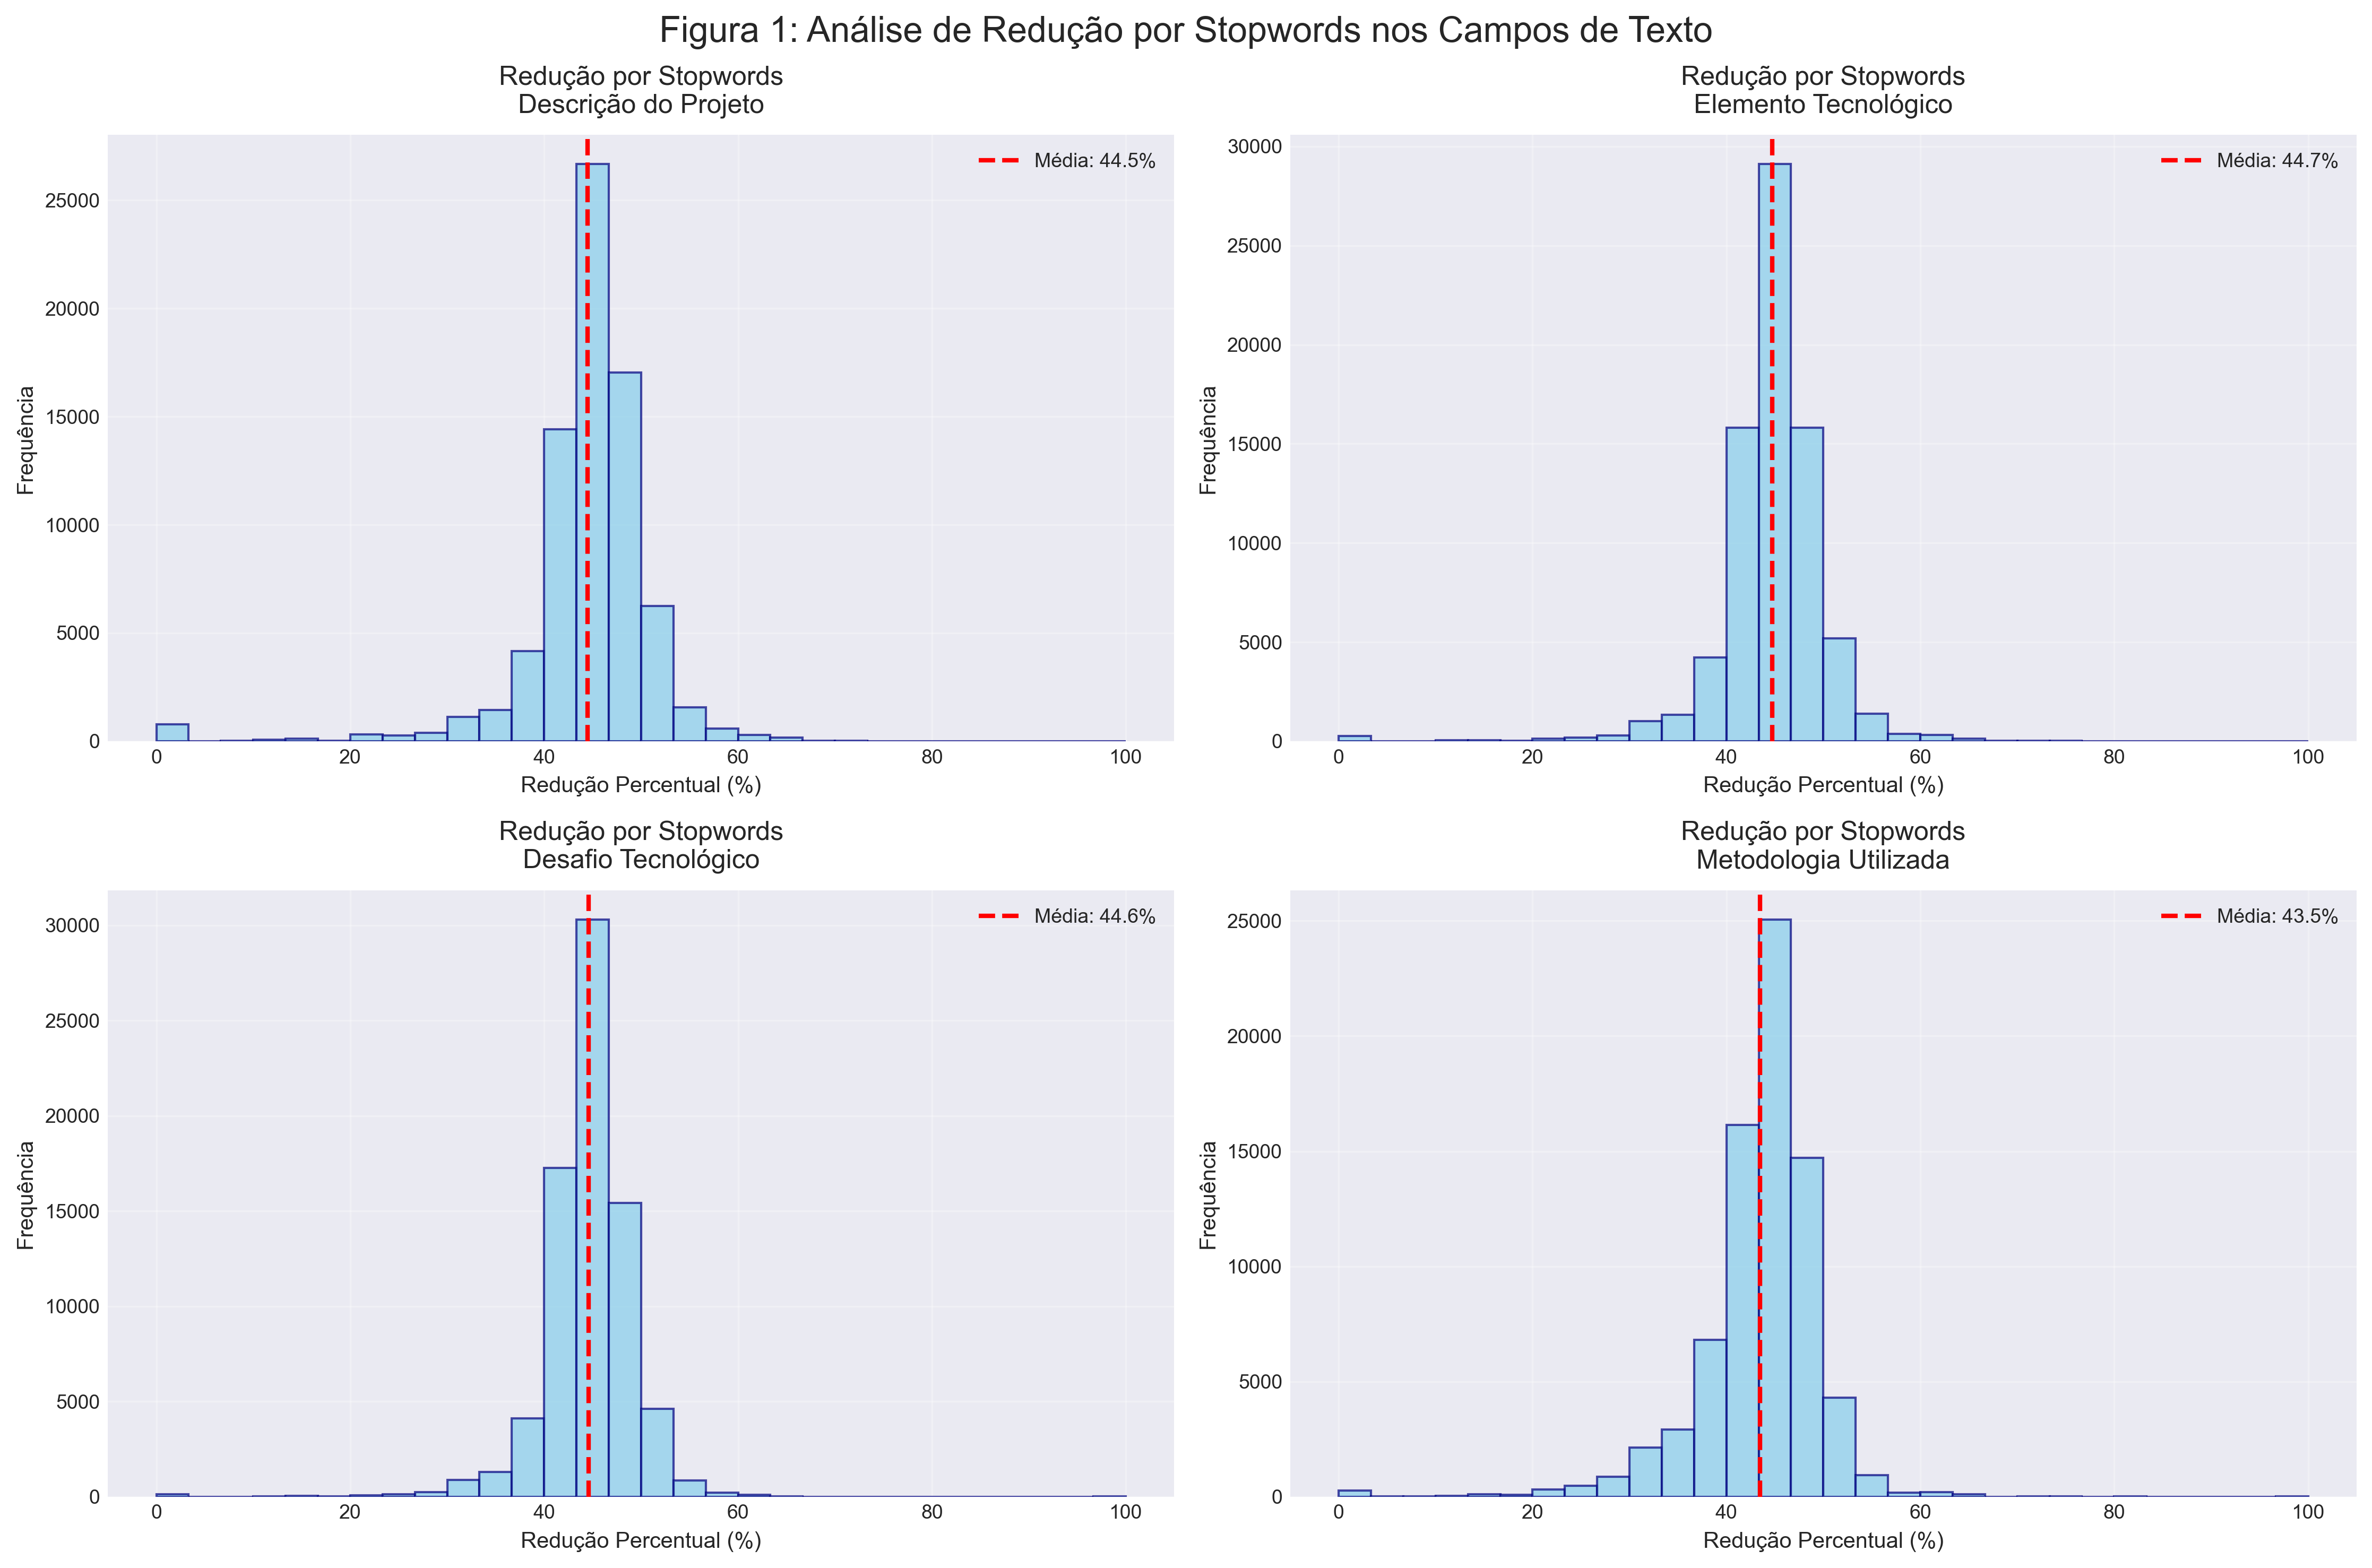

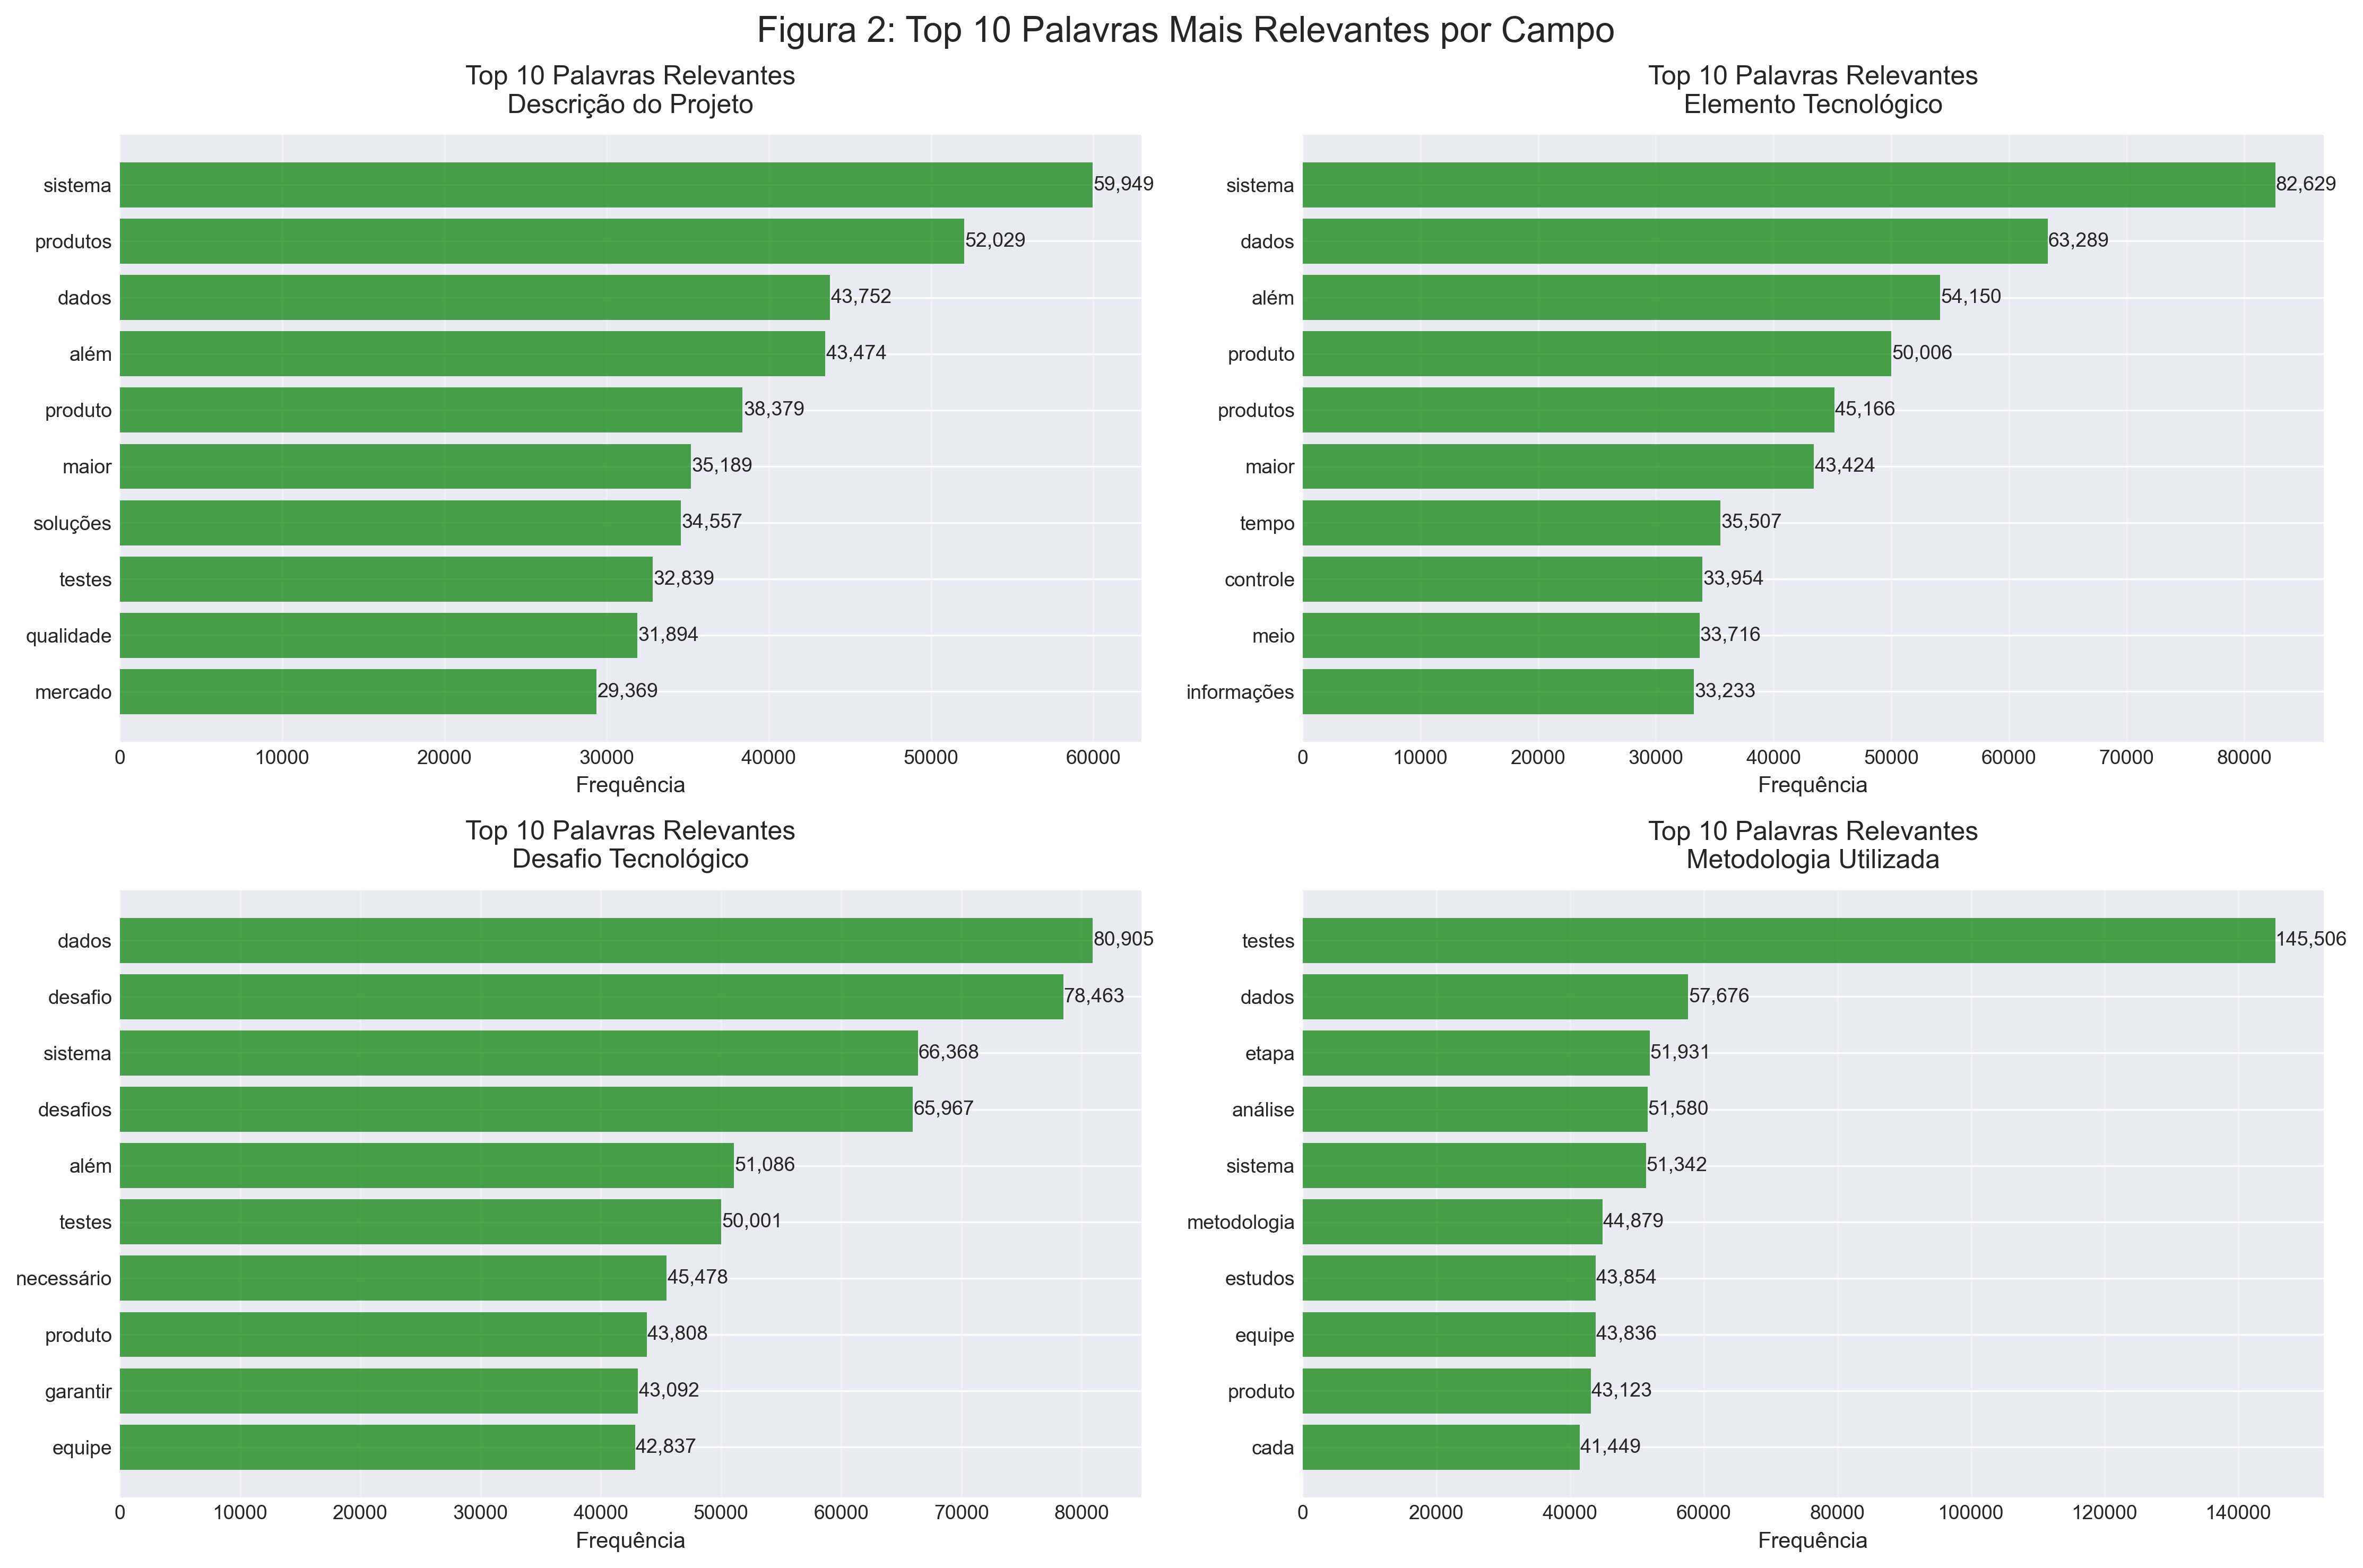


1.5 Preparação Final do Dataset

Criando campo de texto combinado...

Dataset preparado com sucesso!
├── Total de projetos: 75,816
├── Variáveis originais: 17
├── Variáveis criadas: 9
└── Total de variáveis: 26

Exemplo de Processamento (Projeto #1):
------------------------------------------------------------
Original: Em 2018, a Abbott realizou atividades de pesquisa e desenvolvimento de medicamentos e polivitamínicos. As limitações técnicas deste projeto envolvem i...
Limpo: 2018, abbott realizou medicamentos polivitamínicos. limitações técnicas deste envolvem incertezas relação estabilidade fórmulas desenvolvidas, eficáci...
Redução: 42.0%

CAPÍTULO 1 CONCLUÍDO - Dataset pronto para análise


In [18]:
"""
Capítulo 1: Carregamento e Preparação dos Dados
Análise da Lei do Bem - Ano Base 2021

Este script realiza o carregamento inicial dos dados e prepara o dataset
para análises posteriores, incluindo processamento de linguagem natural
dos campos textuais.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Configuração visual-0
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# =============================================================================
# SEÇÃO 1.1: CARREGAMENTO DO DATASET
# =============================================================================

print("=" * 80)
print("CAPÍTULO 1: CARREGAMENTO E PREPARAÇÃO DOS DADOS")
print("=" * 80)
print("\n1.1 Carregamento do Dataset Principal\n")

# Carregar arquivo CSV principal
arquivo_dados = 'csv_longo/projetos_lei_do_bem_DETALHADO_LINHA_UNICA.csv'
df = pd.read_csv(arquivo_dados, sep=';', encoding='utf-8')

# Estatísticas iniciais
total_projetos = len(df)
total_colunas = len(df.columns)

print(f"Dataset carregado com sucesso!")
print(f"├── Total de projetos: {total_projetos:,}")
print(f"└── Total de variáveis: {total_colunas}")

# =============================================================================
# SEÇÃO 1.2: SELEÇÃO DE VARIÁVEIS RELEVANTES
# =============================================================================

print("\n1.2 Seleção de Variáveis Relevantes\n")

# Definir grupos de colunas por categoria
colunas_identificacao = [
    'lst_idprenchimentosituacaoanalise', 'lst_norazaosocial', 'lst_nrcnpj',
    'lst_noatividadeeconomica', 'daproj_nritem'
]

colunas_projeto = [
    'daproj_noprojeto', 'daproj_dsprojeto', 'do_set_nosetor',
    'daproj_dspalavrachave', 'daproj_dselementotecnologico',
    'daproj_dsdesafiotecnologico', 'daproj_dsmetodologiautilizada'
]

colunas_ministerio = [
    'do_saat_idunicopessoaanalise', 'do_taaproj_notipoavaliacaoanalise'
]

colunas_pesquisador = [
    'p_taaproj_notipoavaliacaoanalise'
]

colunas_valores = [
    'do_aat_vltotaldeclarado', 'do_aat_vltotalparecer'
]

# Combinar todas as colunas
colunas_analise = (colunas_identificacao + colunas_projeto + 
                   colunas_ministerio + colunas_pesquisador + colunas_valores)

# Filtrar apenas colunas existentes no dataset
colunas_existentes = [col for col in colunas_analise if col in df.columns]
df_analise = df[colunas_existentes].copy()

print(f"Variáveis selecionadas por categoria:")
print(f"├── Identificação: {len([c for c in colunas_identificacao if c in colunas_existentes])}")
print(f"├── Projeto: {len([c for c in colunas_projeto if c in colunas_existentes])}")
print(f"├── Ministério: {len([c for c in colunas_ministerio if c in colunas_existentes])}")
print(f"├── Pesquisador: {len([c for c in colunas_pesquisador if c in colunas_existentes])}")
print(f"└── Valores: {len([c for c in colunas_valores if c in colunas_existentes])}")
print(f"\nTotal de variáveis selecionadas: {len(colunas_existentes)}")

# =============================================================================
# SEÇÃO 1.3: ANÁLISE TEXTUAL E PROCESSAMENTO DE LINGUAGEM NATURAL
# =============================================================================

print("\n1.3 Análise Textual e Processamento de Linguagem Natural\n")

# 1.3.1 Identificação de campos textuais
campos_texto = {
    'daproj_dsprojeto': 'Descrição do Projeto',
    'daproj_dselementotecnologico': 'Elemento Tecnológico',
    'daproj_dsdesafiotecnologico': 'Desafio Tecnológico',
    'daproj_dsmetodologiautilizada': 'Metodologia Utilizada'
}

campos_texto_existentes = {k: v for k, v in campos_texto.items() if k in df_analise.columns}
print(f"Campos textuais identificados para análise: {len(campos_texto_existentes)}")

# 1.3.2 Configuração de stopwords
print("\nConfigurando conjunto de stopwords...")

# Baixar stopwords do NLTK se necessário
try:
    stopwords_pt = set(stopwords.words('portuguese'))
except:
    nltk.download('stopwords')
    stopwords_pt = set(stopwords.words('portuguese'))

# Stopwords específicas do domínio Lei do Bem
stopwords_dominio = {
    'ano', 'base', 'projeto', 'projetos', 'empresa', 'empresas',
    'desenvolvimento', 'pesquisa', 'inovação', 'tecnológica',
    'realizar', 'realizado', 'realizada', 'realizados', 'realizadas',
    'objetivo', 'objetivos', 'processo', 'processos', 'atividade',
    'atividades', 'trabalho', 'trabalhos', 'forma', 'formas',
    'através', 'partir', 'sendo', 'foram', 'seja', 'sejam',
    'pode', 'podem', 'deve', 'devem', 'está', 'estão',
    'fazer', 'feito', 'feita', 'ter', 'tem', 'tinha',
    'uso', 'usar', 'usado', 'usada', 'novo', 'nova',
    'novos', 'novas', 'ainda', 'apenas', 'assim', 'então'
}

todas_stopwords = stopwords_pt.union(stopwords_dominio)
print(f"├── Stopwords NLTK português: {len(stopwords_pt)}")
print(f"├── Stopwords domínio específico: {len(stopwords_dominio)}")
print(f"└── Total de stopwords: {len(todas_stopwords)}")

# 1.3.3 Função para processar texto
def processar_texto(texto, stopwords_set):
    """
    Processa um texto removendo stopwords e normalizando.
    
    Args:
        texto: String com o texto a ser processado
        stopwords_set: Conjunto de stopwords a remover
        
    Returns:
        dict: Dicionário com texto processado e estatísticas
    """
    if pd.isna(texto):
        return {
            'texto_original': '',
            'texto_limpo': '',
            'palavras_originais': 0,
            'palavras_limpas': 0,
            'reducao_percentual': 0
        }
    
    # Converter para string e lowercase
    texto_str = str(texto).lower()
    
    # Tokenização simples
    palavras_originais = texto_str.split()
    num_palavras_originais = len(palavras_originais)
    
    # Remover stopwords
    palavras_limpas = [p for p in palavras_originais if p not in stopwords_set]
    num_palavras_limpas = len(palavras_limpas)
    
    # Calcular redução
    reducao = 0 if num_palavras_originais == 0 else (
        (num_palavras_originais - num_palavras_limpas) / num_palavras_originais * 100
    )
    
    return {
        'texto_original': texto_str,
        'texto_limpo': ' '.join(palavras_limpas),
        'palavras_originais': num_palavras_originais,
        'palavras_limpas': num_palavras_limpas,
        'reducao_percentual': reducao
    }

# 1.3.4 Processar todos os campos textuais
print("\nProcessando campos textuais...")

resultados_processamento = {}

for campo, nome in campos_texto_existentes.items():
    print(f"\nProcessando: {nome}")
    
    # Aplicar processamento
    processados = df_analise[campo].apply(lambda x: processar_texto(x, todas_stopwords))
    
    # Extrair resultados
    df_temp = pd.DataFrame(processados.tolist())
    
    # Calcular estatísticas
    palavras_originais_media = df_temp['palavras_originais'].mean()
    palavras_limpas_media = df_temp['palavras_limpas'].mean()
    reducao_media = df_temp['reducao_percentual'].mean()
    
    # Contar palavras mais frequentes após limpeza
    todas_palavras_limpas = ' '.join(df_temp['texto_limpo']).split()
    contador_palavras = Counter(todas_palavras_limpas)
    top_palavras = contador_palavras.most_common(20)
    
    # Armazenar resultados
    resultados_processamento[campo] = {
        'nome': nome,
        'df_processado': df_temp,
        'palavras_originais_media': palavras_originais_media,
        'palavras_limpas_media': palavras_limpas_media,
        'reducao_media': reducao_media,
        'top_palavras': top_palavras
    }
    
    # Adicionar colunas processadas ao dataframe principal
    df_analise[f'{campo}_limpo'] = df_temp['texto_limpo']
    df_analise[f'{campo}_num_palavras_limpo'] = df_temp['palavras_limpas']
    
    print(f"├── Palavras médias (original): {palavras_originais_media:.1f}")
    print(f"├── Palavras médias (limpo): {palavras_limpas_media:.1f}")
    print(f"└── Redução média: {reducao_media:.1f}%")

# =============================================================================
# SEÇÃO 1.4: VISUALIZAÇÕES
# =============================================================================

print("\n1.4 Gerando Visualizações\n")

# Figura 1: Análise de Redução por Stopwords
fig1, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (campo, resultado) in enumerate(resultados_processamento.items()):
    ax = axes[i]
    
    # Histograma de redução percentual
    df_vis = resultado['df_processado']
    df_vis['reducao_percentual'].hist(bins=30, ax=ax, color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Adicionar linha de média
    ax.axvline(resultado['reducao_media'], color='red', linestyle='--', linewidth=2,
               label=f'Média: {resultado["reducao_media"]:.1f}%')
    
    # Configurar eixos e título
    ax.set_title(f'Redução por Stopwords\n{resultado["nome"]}', fontsize=12, pad=10)
    ax.set_xlabel('Redução Percentual (%)')
    ax.set_ylabel('Frequência')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Figura 1: Análise de Redução por Stopwords nos Campos de Texto', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Figura 2: Top Palavras Relevantes
fig2, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (campo, resultado) in enumerate(resultados_processamento.items()):
    ax = axes[i]
    
    # Top 10 palavras
    palavras = [p[0] for p in resultado['top_palavras'][:10]]
    frequencias = [p[1] for p in resultado['top_palavras'][:10]]
    
    # Criar gráfico de barras horizontal
    y_pos = np.arange(len(palavras))
    bars = ax.barh(y_pos, frequencias, color='green', alpha=0.7)
    
    # Configurar eixos
    ax.set_yticks(y_pos)
    ax.set_yticklabels(palavras)
    ax.invert_yaxis()
    ax.set_xlabel('Frequência')
    ax.set_title(f'Top 10 Palavras Relevantes\n{resultado["nome"]}', fontsize=12, pad=10)
    ax.grid(axis='x', alpha=0.3)
    
    # Adicionar valores nas barras
    for j, (bar, freq) in enumerate(zip(bars, frequencias)):
        ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
                f'{freq:,}', va='center', fontsize=9)

plt.suptitle('Figura 2: Top 10 Palavras Mais Relevantes por Campo', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# =============================================================================
# SEÇÃO 1.5: PREPARAÇÃO FINAL DO DATASET
# =============================================================================

print("\n1.5 Preparação Final do Dataset\n")

# Criar campo de texto combinado
print("Criando campo de texto combinado...")
textos_combinados = []

for idx in range(len(df_analise)):
    partes = []
    for campo in campos_texto_existentes.keys():
        campo_limpo = f'{campo}_limpo'
        if campo_limpo in df_analise.columns:
            texto = str(df_analise[campo_limpo].iloc[idx])
            if texto and texto != 'nan':
                partes.append(texto)
    
    texto_combinado = ' '.join(partes)
    textos_combinados.append(texto_combinado)

df_analise['texto_combinado_limpo'] = textos_combinados

# Estatísticas finais
print(f"\nDataset preparado com sucesso!")
print(f"├── Total de projetos: {len(df_analise):,}")
print(f"├── Variáveis originais: {len(colunas_existentes)}")
print(f"├── Variáveis criadas: {len([c for c in df_analise.columns if 'limpo' in c])}")
print(f"└── Total de variáveis: {len(df_analise.columns)}")

# Exemplo de processamento
print("\nExemplo de Processamento (Projeto #1):")
print("-" * 60)
campo_exemplo = 'daproj_dsprojeto'
if campo_exemplo in df_analise.columns:
    texto_original = str(df_analise[campo_exemplo].iloc[0])[:150]
    texto_limpo = str(df_analise[f'{campo_exemplo}_limpo'].iloc[0])[:150]
    reducao = resultados_processamento[campo_exemplo]['df_processado']['reducao_percentual'].iloc[0]
    
    print(f"Original: {texto_original}...")
    print(f"Limpo: {texto_limpo}...")
    print(f"Redução: {reducao:.1f}%")

print("\n" + "=" * 80)
print("CAPÍTULO 1 CONCLUÍDO - Dataset pronto para análise")
print("=" * 80)

## 2. Análise Exploratória Inicial

In [19]:
# %% Estatísticas básicas
# Verificar valores únicos nas colunas de decisão
print("Valores únicos em 'do_taaproj_notipoavaliacaoanalise' (Pesquisador ad hoc):")
print(df_analise['do_taaproj_notipoavaliacaoanalise'].value_counts())

print("\n\nValores únicos em 'p_taaproj_notipoavaliacaoanalise' (Ministério):")
print(df_analise['p_taaproj_notipoavaliacaoanalise'].value_counts())

# Filtrar apenas projetos que passaram por ambas as fases
df_completo = df_analise[
    df_analise['do_taaproj_notipoavaliacaoanalise'].notna() & 
    df_analise['p_taaproj_notipoavaliacaoanalise'].notna()
].copy()

print(f"\n\nProjetos com análise completa (Pesquisador + Ministério): {len(df_completo):,}")

Valores únicos em 'do_taaproj_notipoavaliacaoanalise' (Pesquisador ad hoc):
do_taaproj_notipoavaliacaoanalise
Recomendado        48112
Não Recomendado    27682
Abonado               19
Name: count, dtype: int64


Valores únicos em 'p_taaproj_notipoavaliacaoanalise' (Ministério):
p_taaproj_notipoavaliacaoanalise
Recomendado        42575
Não Recomendado    25903
Name: count, dtype: int64


Projetos com análise completa (Pesquisador + Ministério): 68,475


## 1. Análise de Quadrante de Decisão

Análise dos quadrantes de decisão entre Pesquisadores e Ministério.

### Análise de Quadrantes de Decisão - Saída do Terminal e Gráficos

Este código realiza uma análise completa da concordância e discordância entre as decisões de dois grupos de avaliadores: pesquisadores (ad hoc) e o ministério. O código primeiro padroniza as decisões em categorias uniformes e filtra apenas os registros com decisões válidas (Recomendado ou Não Recomendado), excluindo 19 projetos classificados como "Outro".
A matriz de decisões mostra a distribuição cruzada das avaliações, revelando que de 68.456 projetos analisados, a maioria (36.660 projetos ou 53,6%) foi recomendada por ambos os avaliadores (Quadrante 1). O Quadrante 4, com 20.794 projetos (30,4%), representa casos onde ambos não recomendaram. Os quadrantes de discordância são menores: Q2 com 5.104 projetos (7,5%) onde o pesquisador recomendou mas o ministério não, e Q3 com 5.898 projetos (8,6%) onde ocorreu o oposto.

#### Tabela 1 - Visualização dos Quadrantes de Decisão

Este diagrama de dispersão representa visualmente os quatro quadrantes usando círculos proporcionais ao número de projetos. O eixo horizontal representa a decisão do ministério e o vertical a do pesquisador. O Q1 (verde, canto superior direito) é o maior círculo com 53,6% dos projetos. O Q4 (cinza, canto inferior esquerdo) é o segundo maior com 30,4%. Os quadrantes de discordância Q2 (vermelho) e Q3 (laranja) são menores e similares em tamanho. As linhas cruzadas dividem o espaço em quatro regiões distintas.
A análise final mostra uma taxa de concordância total de 83,9% (Q1+Q4) e discordância de 16,1% (Q2+Q3). Entre as discordâncias, há um equilíbrio relativo: o ministério é mais rigoroso em 46,4% dos casos discordantes (Q2), enquanto o pesquisador é mais rigoroso em 53,6% dos casos (Q3).

In [ ]:
# Criar função para padronizar as decisões
def padronizar_decisao(decisao):
    if pd.isna(decisao):
        return np.nan
    decisao_str = str(decisao).strip().upper()
    if 'RECOMENDADO' in decisao_str and 'NÃO' not in decisao_str:
        return 'Recomendado'
    elif 'NÃO RECOMENDADO' in decisao_str:
        return 'Não Recomendado'
    else:
        return 'Outro'

# Aplicar padronização
df_completo['decisao_pesquisador'] = df_completo['do_taaproj_notipoavaliacaoanalise'].apply(padronizar_decisao)
df_completo['decisao_ministerio'] = df_completo['p_taaproj_notipoavaliacaoanalise'].apply(padronizar_decisao)

# Filtrar apenas registros com decisões válidas (Recomendado ou Não Recomendado)
df_analise_quadrantes = df_completo[
    (df_completo['decisao_pesquisador'].isin(['Recomendado', 'Não Recomendado'])) & 
    (df_completo['decisao_ministerio'].isin(['Recomendado', 'Não Recomendado']))
].copy()

# Criar análise de quadrantes
print("=" * 80)
print("ANÁLISE DE QUADRANTES DE DECISÃO")
print("=" * 80)

# Criar matriz de contingência (sem "Outro")
matriz_decisoes = pd.crosstab(
    df_analise_quadrantes['decisao_pesquisador'], 
    df_analise_quadrantes['decisao_ministerio'],
    rownames=['Pesquisador (ad hoc)'],
    colnames=['Ministério'],
    margins=True,
    margins_name='Total'
)

print("\n📊 Matriz de Decisões:")
print(matriz_decisoes)

# Calcular quadrantes específicos
quad1 = len(df_analise_quadrantes[(df_analise_quadrantes['decisao_pesquisador'] == 'Recomendado') & 
                                   (df_analise_quadrantes['decisao_ministerio'] == 'Recomendado')])
quad2 = len(df_analise_quadrantes[(df_analise_quadrantes['decisao_pesquisador'] == 'Recomendado') & 
                                   (df_analise_quadrantes['decisao_ministerio'] == 'Não Recomendado')])
quad3 = len(df_analise_quadrantes[(df_analise_quadrantes['decisao_pesquisador'] == 'Não Recomendado') & 
                                   (df_analise_quadrantes['decisao_ministerio'] == 'Recomendado')])
quad4 = len(df_analise_quadrantes[(df_analise_quadrantes['decisao_pesquisador'] == 'Não Recomendado') & 
                                   (df_analise_quadrantes['decisao_ministerio'] == 'Não Recomendado')])

total_projetos_quad = quad1 + quad2 + quad3 + quad4

# Mostrar informação sobre registros excluídos
total_excluidos = len(df_completo) - len(df_analise_quadrantes)
if total_excluidos > 0:
    print(f"\n⚠️ {total_excluidos} projetos foram excluídos da análise por terem decisão 'Outro'")

print("\n\n📊 ANÁLISE POR QUADRANTES:")
print("-" * 60)
print(f"Quadrante 1 - Recomendado por AMBOS (Pesquisador E Ministério):")
print(f"  → {quad1:,} projetos ({quad1/total_projetos_quad*100:.1f}%)")
print(f"\nQuadrante 2 - Recomendado pelo Pesquisador, NÃO pelo Ministério:")
print(f"  → {quad2:,} projetos ({quad2/total_projetos_quad*100:.1f}%)")
print(f"\nQuadrante 3 - NÃO Recomendado pelo Pesquisador, SIM pelo Ministério:")
print(f"  → {quad3:,} projetos ({quad3/total_projetos_quad*100:.1f}%)")
print(f"\nQuadrante 4 - NÃO Recomendado por AMBOS:")
print(f"  → {quad4:,} projetos ({quad4/total_projetos_quad*100:.1f}%)")
print("-" * 60)
print(f"Total: {total_projetos_quad:,} projetos")

# Visualização dos quadrantes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Matriz de calor
matriz_prop = matriz_decisoes.iloc[:-1, :-1] / total_projetos_quad * 100
sns.heatmap(matriz_prop, annot=True, fmt='.1f', cmap='RdYlBu_r', 
            cbar_kws={'label': 'Percentual (%)'}, ax=ax1,
            annot_kws={'size': 14})
ax1.set_title('Matriz de Decisões (%)', fontsize=16, pad=20)
ax1.set_xlabel('Decisão do Ministério', fontsize=12)
ax1.set_ylabel('Decisão do Pesquisador (ad hoc)', fontsize=12)

# Adicionar valores absolutos
for i in range(len(matriz_decisoes.index)-1):
    for j in range(len(matriz_decisoes.columns)-1):
        valor = matriz_decisoes.iloc[i, j]
        ax1.text(j+0.5, i+0.7, f'({valor:,})', 
                ha='center', va='center', fontsize=10, color='black')



#### Gráfico 3 - Matriz de Decisões (%)

Este mapa de calor visualiza a matriz de contingência em formato percentual. As cores seguem uma escala do azul ao vermelho, onde valores mais altos aparecem em vermelho. Cada célula mostra tanto o percentual quanto o número absoluto de projetos entre parênteses. A diagonal principal (superior esquerdo para inferior direito) concentra a maioria dos casos, indicando alta concordância entre avaliadores. A célula vermelha (53,6%) representa o Q1 onde ambos recomendam, enquanto a célula amarela (30,4%) representa o Q4 onde ambos rejeitam.

In [ ]:
# Gráfico 2: Diagrama de quadrantes
ax2.set_xlim(-1.2, 1.2)
ax2.set_ylim(-1.2, 1.2)
ax2.axhline(y=0, color='black', linewidth=2)
ax2.axvline(x=0, color='black', linewidth=2)

# Desenhar quadrantes
cores_quad = ['#2ecc71', '#e74c3c', '#f39c12', '#95a5a6']
labels_quad = [
    f'Q1: Ambos\nRecomendam\n{quad1:,}\n({quad1/total_projetos_quad*100:.1f}%)',
    f'Q2: Pesq. Sim\nMin. Não\n{quad2:,}\n({quad2/total_projetos_quad*100:.1f}%)',
    f'Q3: Pesq. Não\nMin. Sim\n{quad3:,}\n({quad3/total_projetos_quad*100:.1f}%)',
    f'Q4: Ambos\nNão Recomendam\n{quad4:,}\n({quad4/total_projetos_quad*100:.1f}%)'
]

# Posições dos quadrantes
positions = [(0.6, 0.6), (-0.6, 0.6), (-0.6, -0.6), (0.6, -0.6)]
quadrantes = [quad1, quad2, quad3, quad4]

for i, (pos, label, cor, valor) in enumerate(zip(positions, labels_quad, cores_quad, quadrantes)):
    # Calcular tamanho do círculo proporcional ao valor
    size = (valor / total_projetos_quad) * 5000 + 500
    ax2.scatter(pos[0], pos[1], s=size, c=cor, alpha=0.6, edgecolors='black', linewidth=2)
    ax2.text(pos[0], pos[1], label, ha='center', va='center', fontsize=11, 
             fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', facecolor=cor, alpha=0.3))

ax2.set_xlabel('← Não Recomendado pelo Ministério | Recomendado pelo Ministério →', fontsize=12)
ax2.set_ylabel('← Não Recomendado pelo Pesquisador | Recomendado pelo Pesquisador →', fontsize=12)
ax2.set_title('Visualização dos Quadrantes de Decisão', fontsize=16, pad=20)
ax2.grid(True, alpha=0.3)

# Remover ticks
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()

# Taxa de concordância
concordancia = (quad1 + quad4) / total_projetos_quad * 100
discordancia = (quad2 + quad3) / total_projetos_quad * 100

print(f"\n📊 MÉTRICAS DE CONCORDÂNCIA:")
print(f"Taxa de Concordância Total: {concordancia:.1f}%")
print(f"Taxa de Discordância Total: {discordancia:.1f}%")
print(f"\nDentro das discordâncias:")
print(f"  - Pesquisador mais rigoroso (Q2): {quad3/(quad2+quad3)*100:.1f}%")
print(f"  - Ministério mais rigoroso (Q3): {quad2/(quad2+quad3)*100:.1f}%")

## 2. Análise de Aprovação por Setor

Análise das taxas de aprovação por setor nas fases DO e Parecer, identificando padrões setoriais e diferenças entre as fases de avaliação.

### Análise por Setor

Este bloco de código executa uma análise detalhada das taxas de aprovação de projetos organizados por área/setor. O código primeiro padroniza as decisões dos avaliadores (analista/DO e parecerista/Parecer) em três categorias: "Recomendado", "Não Recomendado" ou "Outro". Em seguida, filtra os dados para incluir apenas projetos com área definida, resultando em 68.443 projetos válidos distribuídos em 7 áreas únicas.

A saída apresenta a distribuição das áreas ordenadas por volume, sendo TIC a maior com 18.772 projetos, seguida por Química e Farmácia com 12.845 projetos. O código calcula estatísticas gerais mostrando uma taxa média de aprovação de 61,3% na fase DO e 63,6% na fase Parecer, com uma diferença média positiva de 2,3% entre as fases.

A tabela principal exibe as 20 principais áreas por volume, mostrando para cada uma: o total de projetos, as taxas de aprovação em cada fase (DO e Parecer), a diferença percentual entre as fases e o número de projetos que mudaram de decisão entre as avaliações. Por exemplo, TIC apresenta 19,6% de projetos que mudaram de decisão (3.676 de 18.772 projetos).

A seção de destaques identifica padrões importantes: áreas com maiores taxas de aprovação em cada fase, áreas com maior queda ou aumento entre as fases DO e Parecer, e áreas com maior taxa de mudança de decisão. Metalurgia e Mineração lidera com 15,9% de projetos que mudaram de decisão, indicando maior discordância entre avaliadores neste setor. O código fornece uma visão abrangente do desempenho de aprovação por setor e identifica onde há maior convergência ou divergência entre as duas fases de avaliação.

In [21]:
# Análise de aprovação por área do projeto
print("\n📊 ANÁLISE DE APROVAÇÃO POR ÁREA DO PROJETO")
print("=" * 80)

# Função para padronizar decisões (mantém a mesma)
def padronizar_decisao(decisao):
    if pd.isna(decisao):
        return np.nan
    decisao_str = str(decisao).strip().upper()
    if 'RECOMENDADO' in decisao_str and 'NÃO' not in decisao_str:
        return 'Recomendado'
    elif 'NÃO RECOMENDADO' in decisao_str:
        return 'Não Recomendado'
    else:
        return 'Outro'

# Aplicar padronização
df_completo['decisao_analista'] = df_completo['do_taaproj_notipoavaliacaoanalise'].apply(padronizar_decisao)
df_completo['decisao_parecerista'] = df_completo['p_taaproj_notipoavaliacaoanalise'].apply(padronizar_decisao)

# Verificar se a coluna de área do projeto existe
if 'do_set_nosetor' in df_completo.columns:
    print("✅ Usando coluna 'do_set_nosetor' (Área do Projeto)")
    
    # Filtrar registros com área definida
    df_com_area = df_completo[df_completo['do_set_nosetor'].notna()].copy()
    print(f"📊 Projetos com área definida: {len(df_com_area):,}")
    
    # Mostrar distribuição das áreas
    print("\n📊 Distribuição das Áreas de Projeto:")
    dist_areas = df_com_area['do_set_nosetor'].value_counts()
    print(f"Total de áreas únicas: {len(dist_areas)}")
    print("\nTop 15 áreas por volume:")
    for i, (area, count) in enumerate(dist_areas.head(15).items()):
        print(f"{i+1:2d}. {area}: {count:,} projetos")
    
    # Calcular estatísticas por área
    analise_por_area = []
    
    for area in df_com_area['do_set_nosetor'].unique():
        if pd.notna(area):
            projetos_area = df_com_area[df_com_area['do_set_nosetor'] == area]
            
            # Estatísticas DO (Analista)
            total_do = len(projetos_area[projetos_area['decisao_analista'].notna()])
            aprovados_do = len(projetos_area[projetos_area['decisao_analista'] == 'Recomendado'])
            taxa_do = (aprovados_do / total_do * 100) if total_do > 0 else 0
            
            # Estatísticas Parecer (Parecerista)
            total_parecer = len(projetos_area[projetos_area['decisao_parecerista'].notna()])
            aprovados_parecer = len(projetos_area[projetos_area['decisao_parecerista'] == 'Recomendado'])
            taxa_parecer = (aprovados_parecer / total_parecer * 100) if total_parecer > 0 else 0
            
            # Projetos que mudaram de decisão
            projetos_duas_fases = projetos_area[
                (projetos_area['decisao_analista'].notna()) & 
                (projetos_area['decisao_parecerista'].notna())
            ]
            
            mudou_decisao = 0
            if len(projetos_duas_fases) > 0:
                mudou_decisao = len(projetos_duas_fases[
                    projetos_duas_fases['decisao_analista'] != projetos_duas_fases['decisao_parecerista']
                ])
            
            analise_por_area.append({
                'Area_Projeto': area,
                'Total_Projetos': len(projetos_area),
                'Total_DO': total_do,
                'Aprovados_DO': aprovados_do,
                'Taxa_Aprovacao_DO_%': taxa_do,
                'Total_Parecer': total_parecer,
                'Aprovados_Parecer': aprovados_parecer,
                'Taxa_Aprovacao_Parecer_%': taxa_parecer,
                'Diferenca_Taxa_%': taxa_parecer - taxa_do,
                'Projetos_Mudaram_Decisao': mudou_decisao,
                'Taxa_Mudanca_%': (mudou_decisao / len(projetos_duas_fases) * 100) if len(projetos_duas_fases) > 0 else 0
            })

# Criar DataFrame com resultados
    df_areas = pd.DataFrame(analise_por_area)
    df_areas = df_areas.sort_values('Total_Projetos', ascending=False)
    
    # Estatísticas gerais
    print(f"\n📊 ESTATÍSTICAS GERAIS:")
    print(f"Total de áreas analisadas: {len(df_areas)}")
    print(f"Taxa média de aprovação DO: {df_areas['Taxa_Aprovacao_DO_%'].mean():.1f}%")
    print(f"Taxa média de aprovação Parecer: {df_areas['Taxa_Aprovacao_Parecer_%'].mean():.1f}%")
    print(f"Diferença média (Parecer - DO): {df_areas['Diferenca_Taxa_%'].mean():.1f}%")
    
    # Tabela resumo
    print("\n📋 TABELA DE APROVAÇÃO POR ÁREA DO PROJETO (Top 20 por volume)")
    print("=" * 130)
    print(f"{'Área do Projeto':<40} {'Projetos':>10} {'Taxa DO':>12} {'Taxa Parecer':>12} {'Diferença':>12} {'Mudaram':>10}")
    print("-" * 130)
    
    for _, row in df_areas.head(20).iterrows():
        area = row['Area_Projeto'][:38] + '..' if len(row['Area_Projeto']) > 40 else row['Area_Projeto']
        print(f"{area:<40} {row['Total_Projetos']:>10} "
              f"{row['Taxa_Aprovacao_DO_%']:>11.1f}% {row['Taxa_Aprovacao_Parecer_%']:>11.1f}% "
              f"{row['Diferenca_Taxa_%']:>11.1f}% {row['Projetos_Mudaram_Decisao']:>10}")
    
    print("=" * 130)
    
    # Destaques
    print("\n🔍 DESTAQUES DA ANÁLISE POR ÁREA DO PROJETO:")
    
    print(f"\nÁreas com MAIOR taxa de aprovação no DO:")
    top_do = df_areas.nlargest(5, 'Taxa_Aprovacao_DO_%')
    for _, row in top_do.iterrows():
        print(f"  - {row['Area_Projeto']}: {row['Taxa_Aprovacao_DO_%']:.1f}% ({row['Total_Projetos']} projetos)")
    
    print(f"\nÁreas com MAIOR taxa de aprovação no Parecer:")
    top_parecer = df_areas.nlargest(5, 'Taxa_Aprovacao_Parecer_%')
    for _, row in top_parecer.iterrows():
        print(f"  - {row['Area_Projeto']}: {row['Taxa_Aprovacao_Parecer_%']:.1f}% ({row['Total_Projetos']} projetos)")
    
    print(f"\nÁreas com MAIOR QUEDA entre DO e Parecer:")
    maior_queda = df_areas.nsmallest(5, 'Diferenca_Taxa_%')
    for _, row in maior_queda.iterrows():
        if row['Diferenca_Taxa_%'] < 0:
            print(f"  - {row['Area_Projeto']}: {row['Diferenca_Taxa_%']:.1f}% de queda ({row['Total_Projetos']} projetos)")
    
    print(f"\nÁreas com MAIOR AUMENTO entre DO e Parecer:")
    maior_aumento = df_areas.nlargest(5, 'Diferenca_Taxa_%')
    for _, row in maior_aumento.iterrows():
        if row['Diferenca_Taxa_%'] > 0:
            print(f"  - {row['Area_Projeto']}: +{row['Diferenca_Taxa_%']:.1f}% de aumento ({row['Total_Projetos']} projetos)")
    
    print(f"\nÁreas com MAIOR taxa de mudança de decisão:")
    maior_mudanca = df_areas.nlargest(5, 'Taxa_Mudanca_%')
    for _, row in maior_mudanca.iterrows():
        if row['Taxa_Mudanca_%'] > 0:
            print(f"  - {row['Area_Projeto']}: {row['Taxa_Mudanca_%']:.1f}% mudaram decisão ({row['Projetos_Mudaram_Decisao']} de {row['Total_Projetos']} projetos)")

else:
    print("❌ Coluna 'do_set_nosetor' não encontrada no dataset")
    # Lista alternativas disponíveis
    print("Colunas disponíveis que podem conter informação de categoria:")
    for col in df_completo.columns:
        if 'area' in col.lower() or 'setor' in col.lower() or 'atividade' in col.lower():
            print(f"  - {col}")


📊 ANÁLISE DE APROVAÇÃO POR ÁREA DO PROJETO
✅ Usando coluna 'do_set_nosetor' (Área do Projeto)
📊 Projetos com área definida: 68,443

📊 Distribuição das Áreas de Projeto:
Total de áreas únicas: 7

Top 15 áreas por volume:
 1. TIC: 18,772 projetos
 2. Química e Farmácia: 12,845 projetos
 3. Mecânica e Transporte: 9,068 projetos
 4. Agroindústria e Alimentos: 8,144 projetos
 5. Transversal: 7,467 projetos
 6. Eletroeletrônica: 7,158 projetos
 7. Metalurgia e Mineração: 4,989 projetos

📊 ESTATÍSTICAS GERAIS:
Total de áreas analisadas: 7
Taxa média de aprovação DO: 61.3%
Taxa média de aprovação Parecer: 63.6%
Diferença média (Parecer - DO): 2.3%

📋 TABELA DE APROVAÇÃO POR ÁREA DO PROJETO (Top 20 por volume)
Área do Projeto                            Projetos      Taxa DO Taxa Parecer    Diferença    Mudaram
----------------------------------------------------------------------------------------------------------------------------------
TIC                                           18772    

### Visualização por Setor

#### Gráfico 4 - Taxa de Aprovação por Área do Projeto: Comparação DO vs Parecer
Este gráfico de barras agrupadas compara as taxas de aprovação entre duas fases de avaliação (DO e Parecer) para as 15 áreas com maior volume de projetos. As barras azuis representam a taxa de aprovação na fase DO (primeira avaliação) e as barras vermelhas representam a taxa na fase Parecer (segunda avaliação). Cada par de barras corresponde a uma área específica, com os valores percentuais exibidos acima de cada barra. O eixo vertical mostra a taxa de aprovação em percentual, variando de 0 a 100%. As áreas estão ordenadas por volume total de projetos, sendo TIC a área com maior número de projetos analisados. A grade
horizontal facilita a leitura dos valores percentuais.

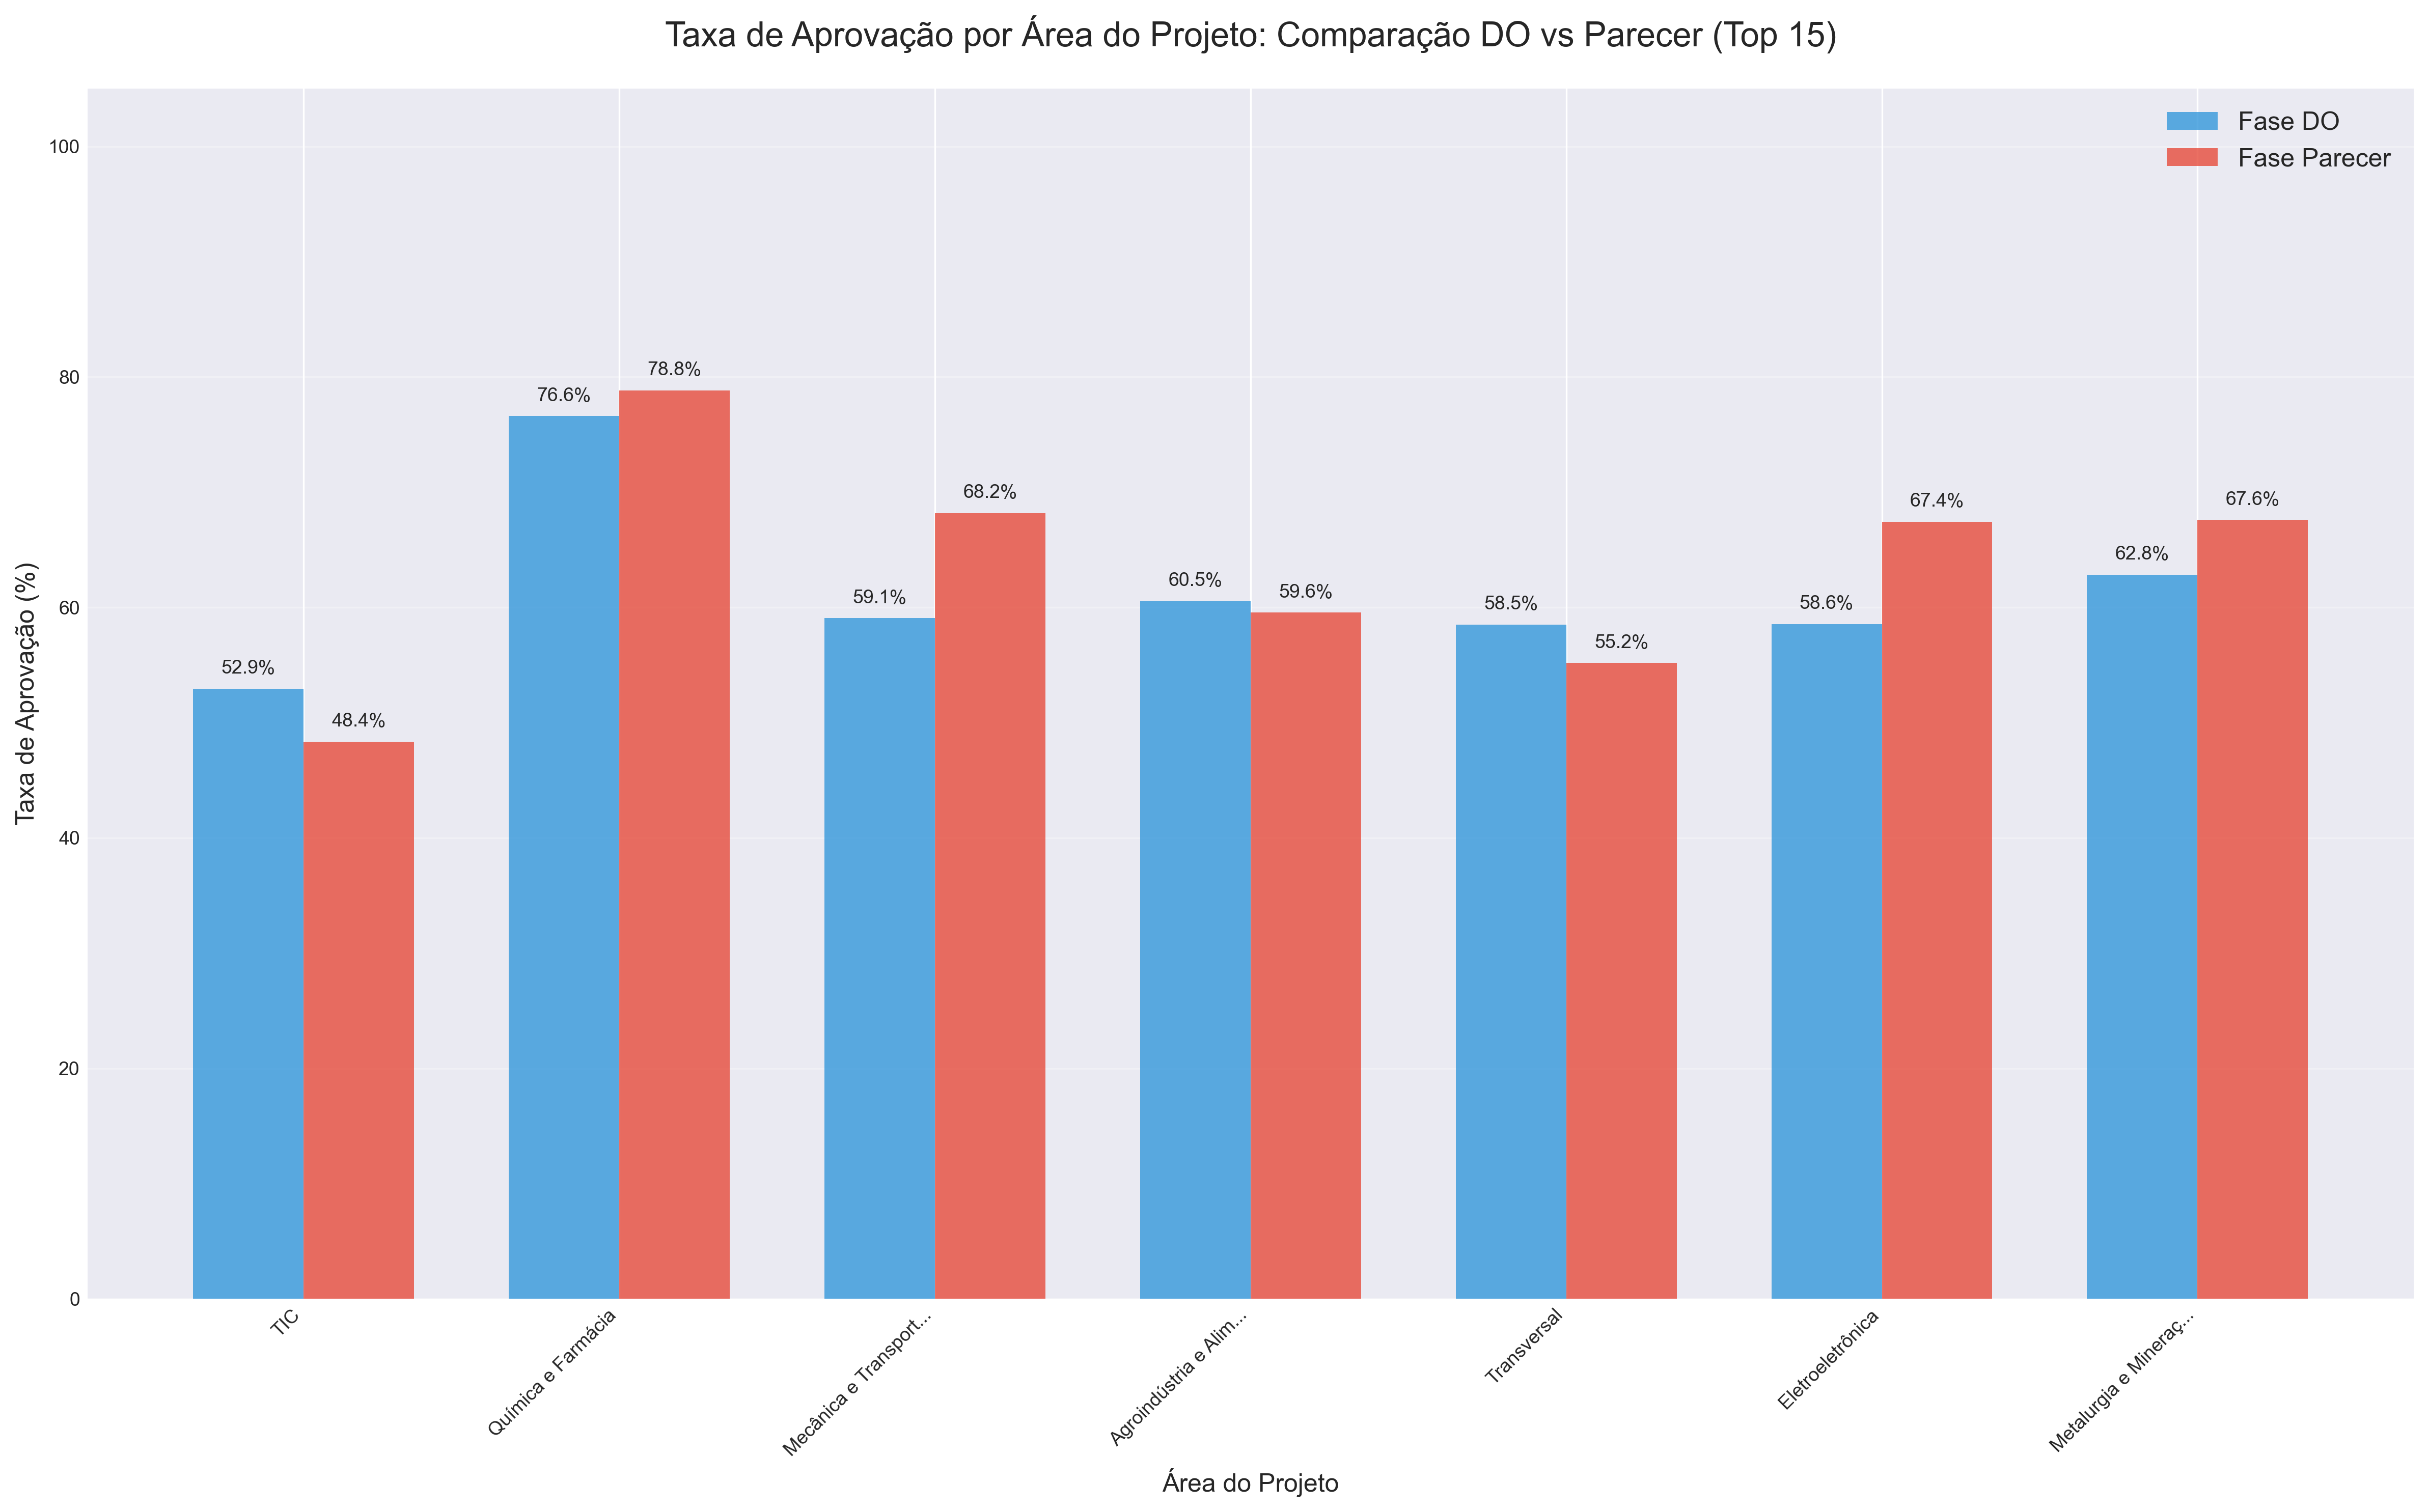

In [27]:
# Visualizações para análise por área
if 'df_areas' in locals() and len(df_areas) > 0:
    
    # Visualização 1: Gráfico de barras comparativo DO vs Parecer
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Preparar dados (top 15 áreas por volume)
    top_areas = df_areas.head(15)
    x = np.arange(len(top_areas))
    width = 0.35
    
    # Barras
    bars1 = ax.bar(x - width/2, top_areas['Taxa_Aprovacao_DO_%'], width, 
                   label='Fase DO', color='#3498db', alpha=0.8)
    bars2 = ax.bar(x + width/2, top_areas['Taxa_Aprovacao_Parecer_%'], width,
                   label='Fase Parecer', color='#e74c3c', alpha=0.8)
    
    # Adicionar valores nas barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Configurar eixos
    ax.set_xlabel('Área do Projeto', fontsize=12)
    ax.set_ylabel('Taxa de Aprovação (%)', fontsize=12)
    ax.set_title('Taxa de Aprovação por Área do Projeto: Comparação DO vs Parecer (Top 15)', fontsize=16, pad=20)
    ax.set_xticks(x)
    
    # Labels das áreas (truncar se muito longo)
    labels_areas = [area[:20] + '...' if len(area) > 20 else area for area in top_areas['Area_Projeto']]
    ax.set_xticklabels(labels_areas, rotation=45, ha='right')
    
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim(0, 105)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\n❌ Não foi possível realizar a análise por área do projeto")
    print("Verifique se a coluna 'do_set_nosetor' existe e contém dados válidos")

### Gráfico 5 - Correlação entre Taxas de Aprovação DO e Parecer por Área do Projeto
Este gráfico de dispersão mostra a relação entre as taxas de aprovação das duas fases de avaliação. No eixo horizontal está a
taxa de aprovação na fase DO e no eixo vertical a taxa na fase Parecer. Cada círculo representa uma área diferente, sendo que o
tamanho do círculo é proporcional ao número total de projetos daquela área (círculos maiores indicam áreas com mais projetos).
A cor dos círculos segue uma escala que vai do vermelho ao azul, representando a diferença percentual entre as taxas (Parecer
menos DO). A linha diagonal tracejada representa o ponto onde as taxas seriam iguais nas duas fases. Áreas específicas como
TIC, Química e Farmácia, e Mecânica e Transporte estão identificadas com rótulos devido ao seu volume significativo ou diferença
expressiva entre as fases.

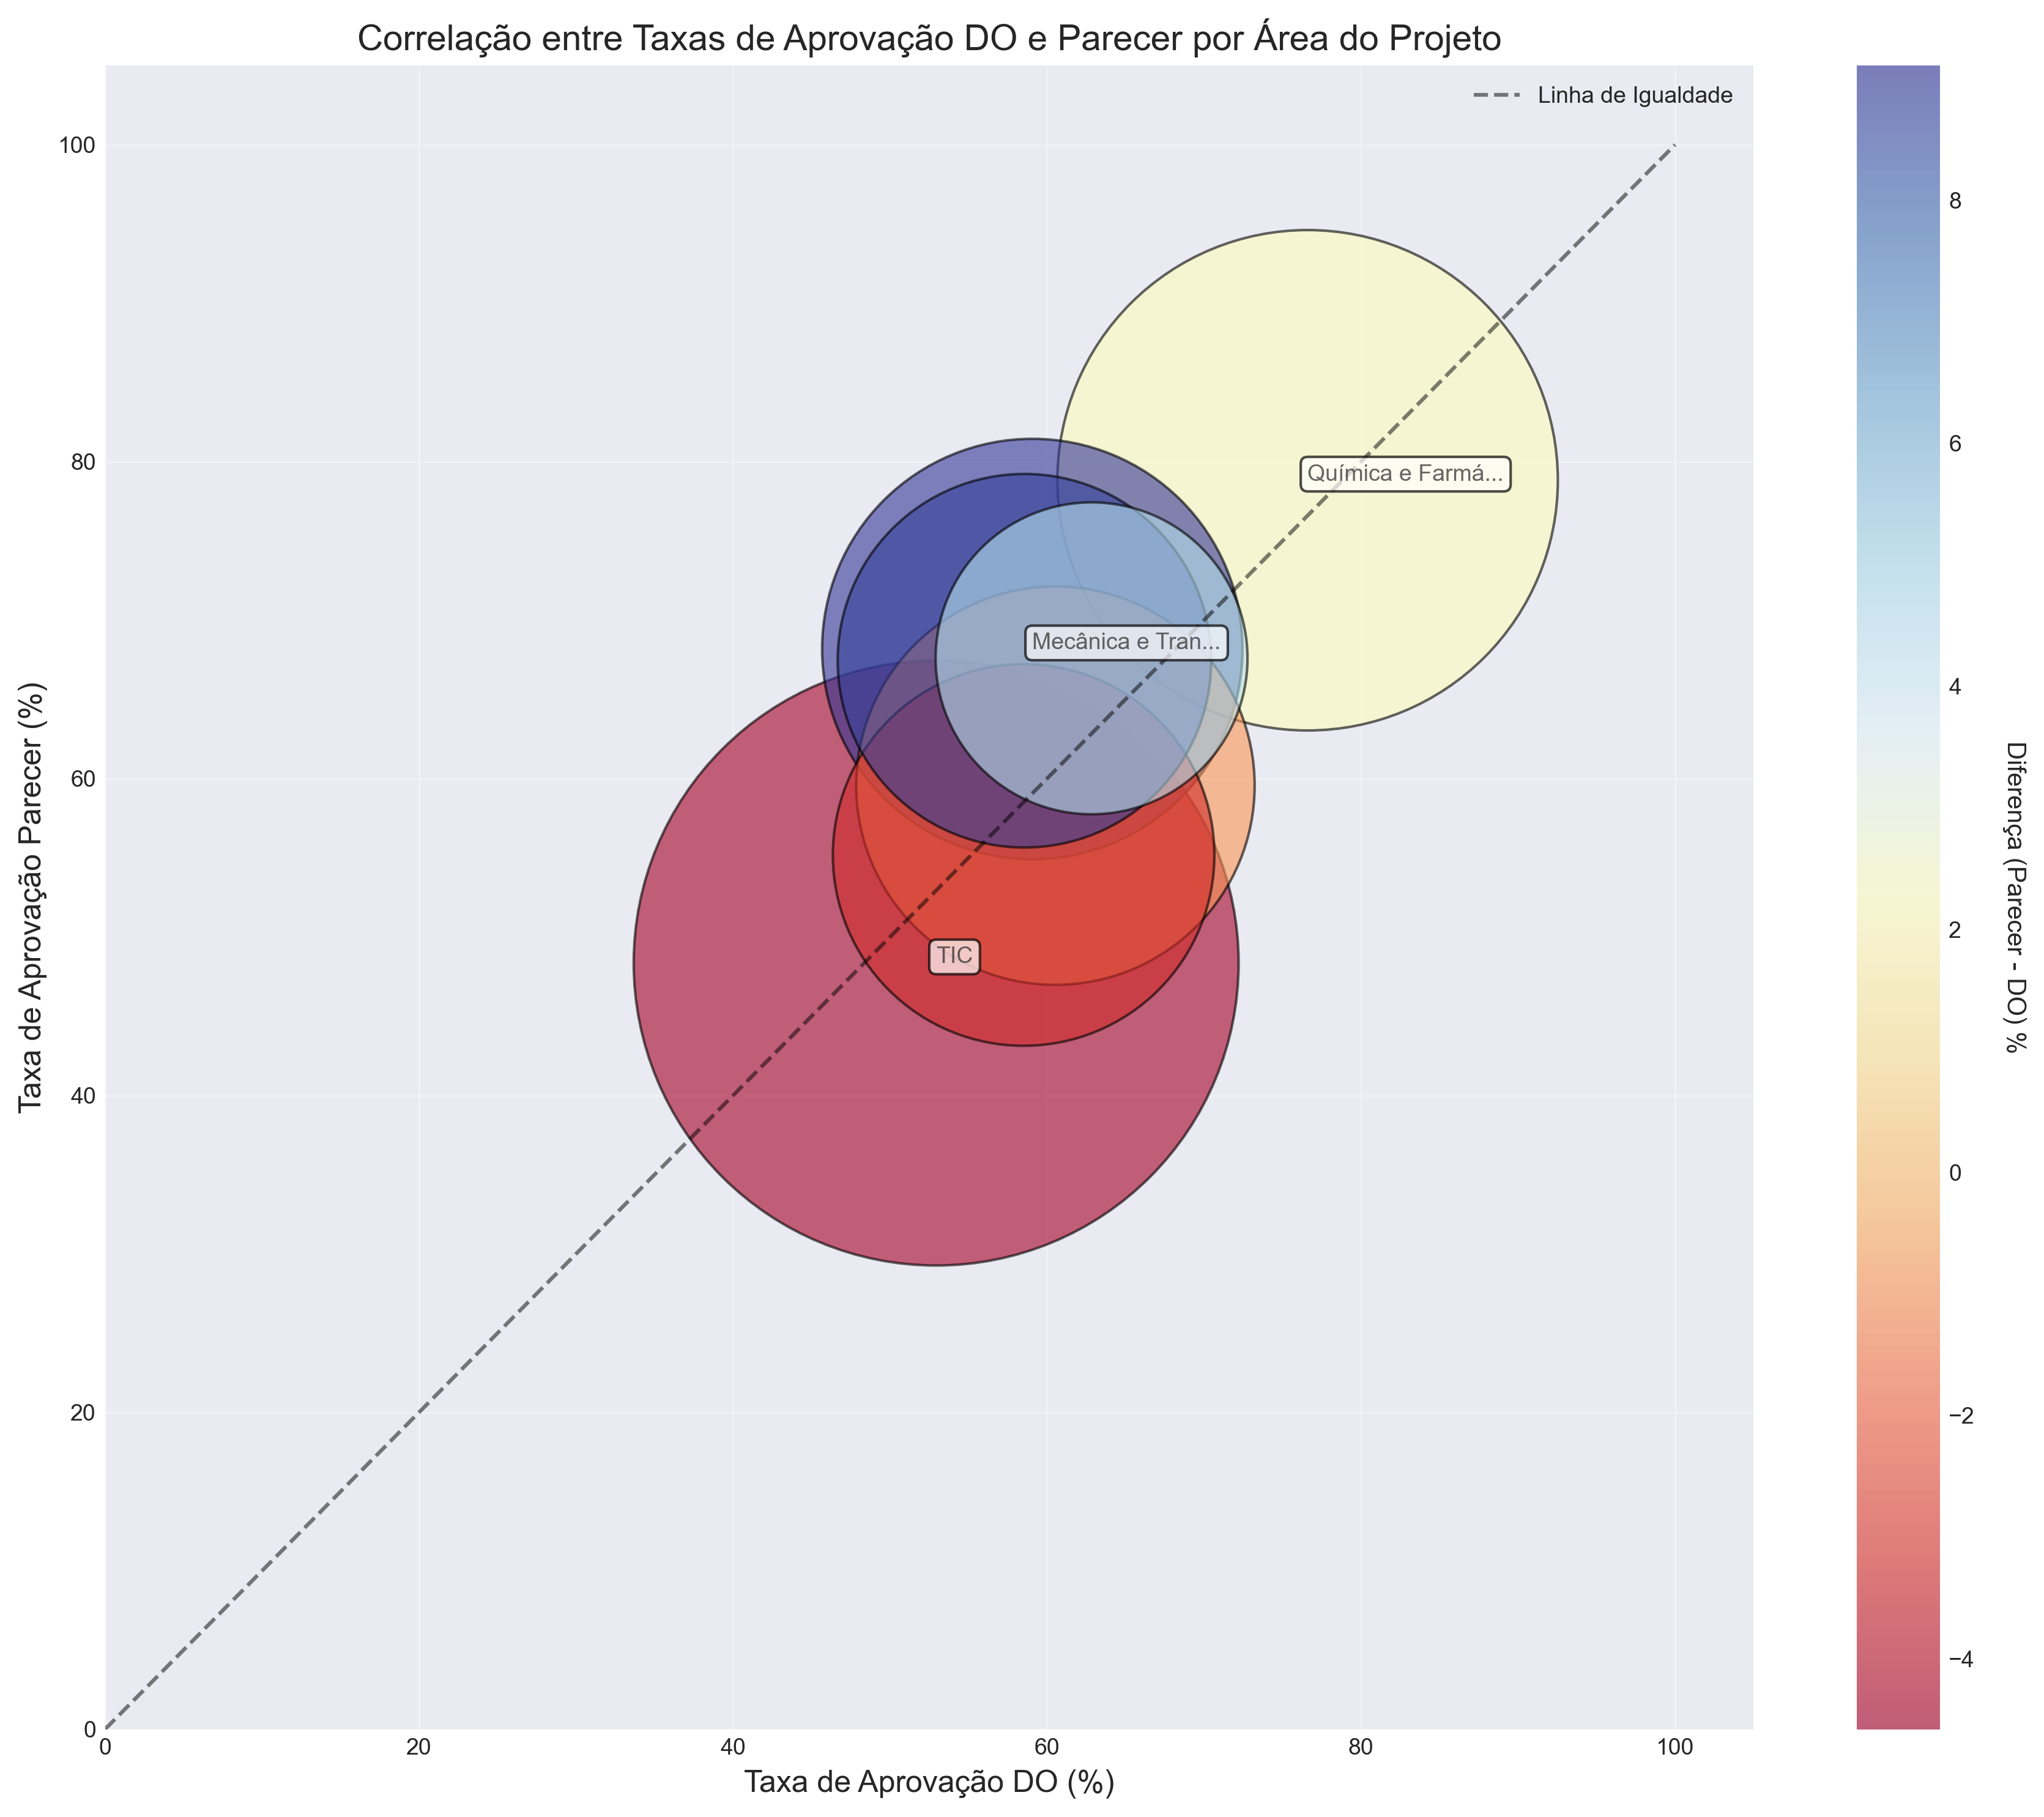

In [28]:
if 'df_areas' in locals() and len(df_areas) > 0:
    # Visualização 2: Scatter plot - Taxa DO vs Taxa Parecer
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Filtrar áreas com pelo menos 20 projetos para melhor visualização
    df_scatter = df_areas[df_areas['Total_Projetos'] >= 20]
    
    if len(df_scatter) > 0:
        scatter = ax.scatter(df_scatter['Taxa_Aprovacao_DO_%'], 
                           df_scatter['Taxa_Aprovacao_Parecer_%'],
                           s=df_scatter['Total_Projetos']*3,  # Tamanho proporcional
                           c=df_scatter['Diferenca_Taxa_%'],
                           cmap='RdYlBu', alpha=0.6, edgecolors='black', linewidth=1)
        
        # Linha de referência (y = x)
        ax.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Linha de Igualdade')
        
        # Adicionar labels para áreas extremas
        for _, row in df_scatter.iterrows():
            if abs(row['Diferenca_Taxa_%']) > 25 or row['Total_Projetos'] > df_scatter['Total_Projetos'].quantile(0.6):
                label_area = row['Area_Projeto'][:15] + '...' if len(row['Area_Projeto']) > 15 else row['Area_Projeto']
                ax.annotate(label_area, 
                          (row['Taxa_Aprovacao_DO_%'], row['Taxa_Aprovacao_Parecer_%']),
                          fontsize=9, alpha=0.7, 
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        ax.set_xlabel('Taxa de Aprovação DO (%)', fontsize=12)
        ax.set_ylabel('Taxa de Aprovação Parecer (%)', fontsize=12)
        ax.set_title('Correlação entre Taxas de Aprovação DO e Parecer por Área do Projeto', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 105)
        ax.legend()
        
        # Colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Diferença (Parecer - DO) %', rotation=270, labelpad=20)
        
        plt.tight_layout()
        plt.show()
    else:
        print("\n❌ Não foi possível realizar a análise por área do projeto")
        print("Verifique se a coluna 'do_set_nosetor' existe e contém dados válidos")

#### Gráfico 6 - Análise Detalhada por Área do Projeto
Este mapa de calor apresenta uma visão consolidada de quatro métricas diferentes para as 20 áreas com maior volume de projetos.
As linhas representam: Taxa de Aprovação DO, Taxa de Aprovação Parecer, Taxa de Mudança de Decisão (percentual de projetos
que tiveram decisão diferente entre as fases) e Diferença (Parecer-DO). Cada célula contém o valor numérico da métrica e é
colorida segundo uma escala que vai do azul escuro (valores mais negativos) ao vermelho escuro (valores mais positivos), com o
branco representando valores próximos a zero. Esta escala de cores está centrada em zero, facilitando a identificação visual de
valores positivos e negativos, especialmente útil para a linha de Diferença onde valores negativos indicam queda na taxa de
aprovação e positivos indicam aumento.

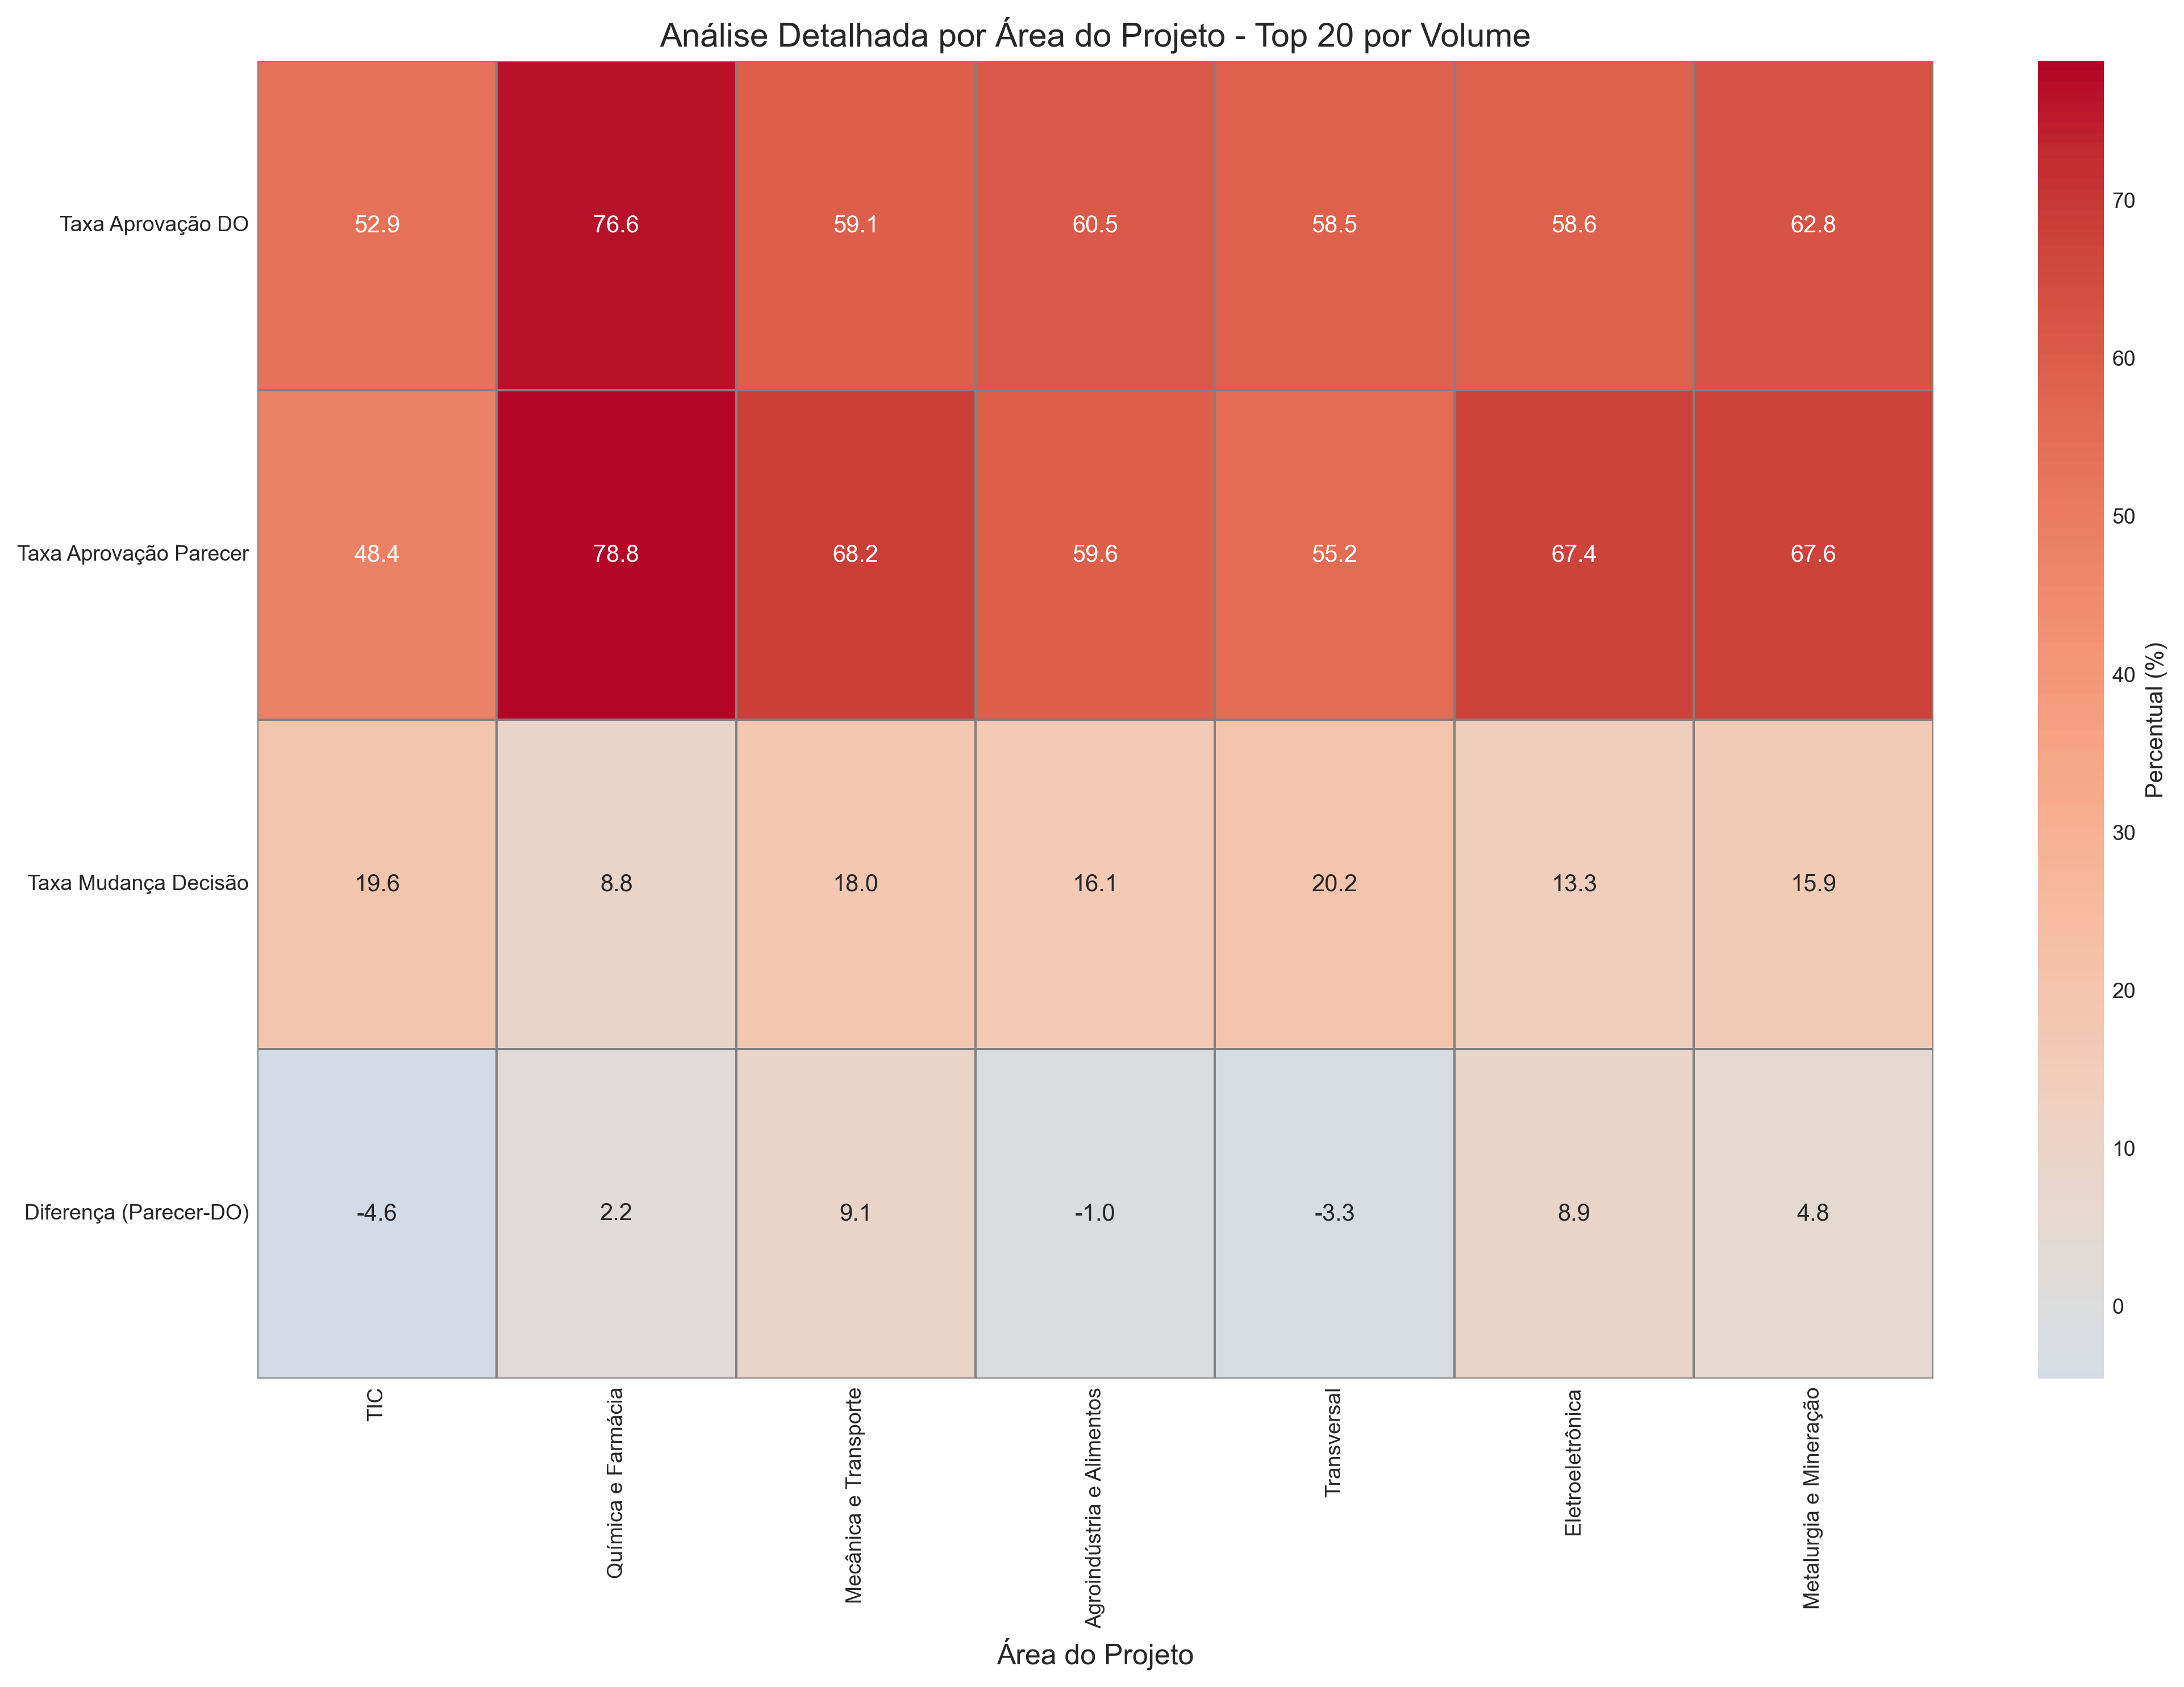


💾 Resultados exportados para 'analise_aprovacao_por_area_projeto.csv'

📊 ESTATÍSTICAS ADICIONAIS:
Áreas com 100% aprovação no Parecer: 0
Áreas com 0% aprovação no Parecer: 0
Área com maior volume: TIC (18772 projetos)
Diferença máxima (Parecer-DO): 9.1%
Diferença mínima (Parecer-DO): -4.6%


In [29]:
if 'df_areas' in locals() and len(df_areas) > 0:
    
    # Visualização 3: Heatmap de análise por área
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Preparar dados para heatmap (top 20 áreas)
    heatmap_data = df_areas.head(20)[['Taxa_Aprovacao_DO_%', 'Taxa_Aprovacao_Parecer_%', 
                                      'Taxa_Mudanca_%', 'Diferenca_Taxa_%']]
    
    # Truncar nomes das áreas para o heatmap
    areas_truncadas = [area[:25] + '...' if len(area) > 25 else area for area in df_areas.head(20)['Area_Projeto']]
    heatmap_data.index = areas_truncadas
    
    sns.heatmap(heatmap_data.T, annot=True, fmt='.1f', cmap='coolwarm', center=0,
               cbar_kws={'label': 'Percentual (%)'}, linewidths=0.5, linecolor='gray')
    
    ax.set_xlabel('Área do Projeto', fontsize=12)
    ax.set_yticklabels(['Taxa Aprovação DO', 'Taxa Aprovação Parecer', 
                      'Taxa Mudança Decisão', 'Diferença (Parecer-DO)'], rotation=0)
    ax.set_title('Análise Detalhada por Área do Projeto - Top 20 por Volume', fontsize=14)
    
    plt.tight_layout()
    plt.show()
        
    # Exportar resultados
    df_areas.to_csv('analise_aprovacao_por_area_projeto.csv', index=False, sep=';', encoding='utf-8')
    print("\n💾 Resultados exportados para 'analise_aprovacao_por_area_projeto.csv'")
    
    # Estatísticas adicionais
    print(f"\n📊 ESTATÍSTICAS ADICIONAIS:")
    print(f"Áreas com 100% aprovação no Parecer: {len(df_areas[df_areas['Taxa_Aprovacao_Parecer_%'] == 100])}")
    print(f"Áreas com 0% aprovação no Parecer: {len(df_areas[df_areas['Taxa_Aprovacao_Parecer_%'] == 0])}")
    print(f"Área com maior volume: {df_areas.iloc[0]['Area_Projeto']} ({df_areas.iloc[0]['Total_Projetos']} projetos)")
    print(f"Diferença máxima (Parecer-DO): {df_areas['Diferenca_Taxa_%'].max():.1f}%")
    print(f"Diferença mínima (Parecer-DO): {df_areas['Diferenca_Taxa_%'].min():.1f}%")

else:
    print("\n❌ Não foi possível realizar a análise por área do projeto")
    print("Verifique se a coluna 'do_set_nosetor' existe e contém dados válidos")

### Análise e Insights por Setor

**O que foi investigado:**

Esta análise focou em identificar padrões de aprovação por setor nas duas fases principais do processo (DO e Parecer), quantificando as diferenças entre as decisões dos analistas técnicos e dos pareceristas para cada setor de atividade.

**Principais Descobertas:**

A análise setorial revela significativas disparidades nas taxas de aprovação entre diferentes setores e entre as fases do processo:

- **Variação Setorial**: As taxas de aprovação variam drasticamente entre setores, tanto na fase DO quanto no Parecer
- **Tendência Geral**: A maioria dos setores apresenta queda na taxa de aprovação entre DO e Parecer, confirmando que os pareceristas aplicam critérios mais rigorosos
- **Setores Favorecidos**: Alguns setores mantêm altas taxas de aprovação em ambas as fases
- **Setores Penalizados**: Certos setores sofrem quedas dramáticas entre as fases

**Padrões Identificados:**

1. **Setores de Alta Performance**: Setores com taxas superiores a 80% em ambas as fases
2. **Setores de Queda Acentuada**: Setores que perdem mais de 20 pontos percentuais entre DO e Parecer
3. **Setores de Reversão**: Raros casos onde a taxa no Parecer supera a do DO
4. **Setores Voláteis**: Alta taxa de mudança de decisão entre fases

**Insights e Implicações Práticas:**

1. **Especialização Setorial**: A variação nas taxas sugere que diferentes setores requerem expertise específica para avaliação adequada

2. **Necessidade de Padronização**: As grandes diferenças entre setores podem indicar falta de critérios uniformes ou vieses setoriais

3. **Oportunidade de Capacitação**: Setores com altas taxas de mudança entre fases podem se beneficiar de treinamento específico para analistas

4. **Revisão de Critérios**: Setores com quedas sistemáticas merecem revisão dos critérios de avaliação aplicados

**Recomendações Específicas:**

- **Criar grupos de trabalho setoriais** para padronizar critérios de avaliação
- **Desenvolver checklists específicos** para cada setor baseados em suas particularidades
- **Implementar revisão cruzada** entre analistas de diferentes setores
- **Monitorar indicadores setoriais** continuamente para identificar tendências
- **Capacitar analistas** nas especificidades técnicas de cada setor

### Análise de Concordância por Área do Projeto - Foco nos Quadrantes 1 e 4

#### Gráfico 7 - Análise de Concordância por Área: Q1 vs Q4

Este gráfico de dispersão apresenta a relação entre duas métricas de concordância. No eixo horizontal (X) está representada a Taxa de Concordância Positiva Q1, que indica o percentual de projetos onde tanto o pesquisador quanto o ministério recomendam o projeto.

No eixo vertical (Y) está a Taxa de Concordância Negativa Q4, representando o percentual onde ambos os avaliadores não recomendam. Cada círculo no gráfico representa uma área diferente, sendo que o tamanho do círculo é proporcional ao número total de projetos daquela área.

A cor dos círculos varia de acordo com a concordância total (Q1+Q4), seguindo uma escala de cores do roxo ao amarelo. As linhas tracejadas indicam as médias de Q1 (54,5%) e Q4 (29,6%), enquanto a linha diagonal representa o ponto de equilíbrio onde Q1 seria igual a Q4. O gráfico inclui apenas áreas com 20 ou mais projetos para garantir representatividade estatística.

In [ ]:
# Análise de Concordância por Área do Projeto - Foco nos Quadrantes 1 e 4
print("=" * 80)
print("ANÁLISE DE CONCORDÂNCIA POR ÁREA DO PROJETO")
print("Foco: Quadrantes 1 (ambos recomendam) e 4 (ambos não recomendam)")
print("=" * 80)

# Verificar se temos os dados necessários
if 'df_analise_quadrantes' in locals() and 'do_set_nosetor' in df_analise_quadrantes.columns:
    
    # Criar classificação de quadrantes
    df_analise_quadrantes['quadrante'] = ''
    df_analise_quadrantes.loc[
        (df_analise_quadrantes['decisao_pesquisador'] == 'Recomendado') & 
        (df_analise_quadrantes['decisao_ministerio'] == 'Recomendado'), 'quadrante'] = 'Q1'
    df_analise_quadrantes.loc[
        (df_analise_quadrantes['decisao_pesquisador'] == 'Recomendado') & 
        (df_analise_quadrantes['decisao_ministerio'] == 'Não Recomendado'), 'quadrante'] = 'Q2'
    df_analise_quadrantes.loc[
        (df_analise_quadrantes['decisao_pesquisador'] == 'Não Recomendado') & 
        (df_analise_quadrantes['decisao_ministerio'] == 'Recomendado'), 'quadrante'] = 'Q3'
    df_analise_quadrantes.loc[
        (df_analise_quadrantes['decisao_pesquisador'] == 'Não Recomendado') & 
        (df_analise_quadrantes['decisao_ministerio'] == 'Não Recomendado'), 'quadrante'] = 'Q4'
    
    # Filtrar apenas áreas com dados válidos
    df_com_area = df_analise_quadrantes[df_analise_quadrantes['do_set_nosetor'].notna()].copy()
    
    # Análise por área
    analise_concordancia_area = []
    
    for area in df_com_area['do_set_nosetor'].unique():
        if pd.notna(area):
            projetos_area = df_com_area[df_com_area['do_set_nosetor'] == area]
            
            # Contagem por quadrante
            q1_count = len(projetos_area[projetos_area['quadrante'] == 'Q1'])
            q2_count = len(projetos_area[projetos_area['quadrante'] == 'Q2'])
            q3_count = len(projetos_area[projetos_area['quadrante'] == 'Q3'])
            q4_count = len(projetos_area[projetos_area['quadrante'] == 'Q4'])
            
            total_area = len(projetos_area)
            concordancia_positiva = q1_count / total_area * 100 if total_area > 0 else 0
            concordancia_negativa = q4_count / total_area * 100 if total_area > 0 else 0
            concordancia_total = (q1_count + q4_count) / total_area * 100 if total_area > 0 else 0
            discordancia_total = (q2_count + q3_count) / total_area * 100 if total_area > 0 else 0
            
            analise_concordancia_area.append({
                'Area': area,
                'Total_Projetos': total_area,
                'Q1_Ambos_Recomendam': q1_count,
                'Q1_Percent': concordancia_positiva,
                'Q4_Ambos_Nao_Recomendam': q4_count,
                'Q4_Percent': concordancia_negativa,
                'Q2_Pesq_Sim_Min_Nao': q2_count,
                'Q3_Pesq_Nao_Min_Sim': q3_count,
                'Concordancia_Total_%': concordancia_total,
                'Discordancia_Total_%': discordancia_total,
                'Razao_Q1_Q4': q1_count / q4_count if q4_count > 0 else float('inf')
            })
    
    # Criar DataFrame
    df_concordancia = pd.DataFrame(analise_concordancia_area)
    df_concordancia = df_concordancia.sort_values('Total_Projetos', ascending=False)
    
    # Estatísticas gerais
    print(f"\n📊 ESTATÍSTICAS GERAIS:")
    print(f"Total de áreas analisadas: {len(df_concordancia)}")
    print(f"Taxa média de concordância total: {df_concordancia['Concordancia_Total_%'].mean():.1f}%")
    print(f"Taxa média de concordância positiva (Q1): {df_concordancia['Q1_Percent'].mean():.1f}%")
    print(f"Taxa média de concordância negativa (Q4): {df_concordancia['Q4_Percent'].mean():.1f}%")
    
    # Top áreas por concordância
    print("\n🏆 TOP 10 ÁREAS COM MAIOR CONCORDÂNCIA TOTAL (Q1+Q4):")
    print("-" * 80)
    top_concordancia = df_concordancia.nlargest(10, 'Concordancia_Total_%')
    for i, row in enumerate(top_concordancia.iterrows(), 1):
        _, area_data = row
        print(f"{i:2d}. {area_data['Area'][:40]:<40} | "
              f"Conc: {area_data['Concordancia_Total_%']:5.1f}% | "
              f"Q1: {area_data['Q1_Percent']:5.1f}% | "
              f"Q4: {area_data['Q4_Percent']:5.1f}% | "
              f"({area_data['Total_Projetos']} projetos)")
    
    # Visualização 1: Scatter plot Q1 vs Q4
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Filtrar áreas com pelo menos 20 projetos
    df_vis = df_concordancia[df_concordancia['Total_Projetos'] >= 20]
    
    # Criar scatter plot
    scatter = ax.scatter(df_vis['Q1_Percent'], df_vis['Q4_Percent'],
                        s=df_vis['Total_Projetos']*2,
                        c=df_vis['Concordancia_Total_%'],
                        cmap='viridis', alpha=0.6,
                        edgecolors='black', linewidth=1)
    
    # Adicionar linhas de referência
    ax.axhline(y=df_vis['Q4_Percent'].mean(), color='red', linestyle='--', alpha=0.5, 
               label=f'Média Q4: {df_vis["Q4_Percent"].mean():.1f}%')
    ax.axvline(x=df_vis['Q1_Percent'].mean(), color='blue', linestyle='--', alpha=0.5,
               label=f'Média Q1: {df_vis["Q1_Percent"].mean():.1f}%')
    
    # Diagonal de equilíbrio
    max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Linha de equilíbrio (Q1=Q4)')
    
    # Anotar áreas extremas
    # Áreas com alta concordância positiva (Q1)
    top_q1 = df_vis.nlargest(3, 'Q1_Percent')
    for _, row in top_q1.iterrows():
        if row['Q1_Percent'] > 70:
            ax.annotate(f"{row['Area'][:20]}...", 
                       (row['Q1_Percent'], row['Q4_Percent']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=9, color='darkblue',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
    
    # Áreas com alta concordância negativa (Q4)
    top_q4 = df_vis.nlargest(3, 'Q4_Percent')
    for _, row in top_q4.iterrows():
        if row['Q4_Percent'] > 50:
            ax.annotate(f"{row['Area'][:20]}...", 
                       (row['Q1_Percent'], row['Q4_Percent']),
                       xytext=(-5, -5), textcoords='offset points',
                       fontsize=9, color='darkred',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
    
    ax.set_xlabel('Taxa de Concordância Positiva - Q1 (%)\n(Ambos Recomendam)', fontsize=12)
    ax.set_ylabel('Taxa de Concordância Negativa - Q4 (%)\n(Ambos Não Recomendam)', fontsize=12)
    ax.set_title('Análise de Concordância por Área: Q1 vs Q4\n(Áreas com ≥20 projetos)', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Concordância Total (%)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ Dados insuficientes para análise de concordância por área do projeto")
    print("Certifique-se de que as colunas 'decisao_pesquisador', 'decisao_ministerio' e 'do_set_nosetor' estão presentes no DataFrame.")

#### Gráfico 8 - Distribuição dos Quadrantes por Área

Este conjunto de dois gráficos de barras mostra a distribuição percentual dos quatro quadrantes de decisão para as 15 áreas com maior volume de projetos. 

O gráfico superior apresenta barras empilhadas onde cada segmento colorido representa um quadrante: verde para Q1 (ambos recomendam), vermelho para Q2 (pesquisador recomenda, ministério não), laranja para Q3 (pesquisador não recomenda, ministério sim) e cinza para Q4 (ambos não recomendam). 

A altura total de cada barra sempre soma 100%, mostrando a distribuição completa das decisões. O gráfico inferior foca especificamente na comparação entre Q1 e Q4, usando barras lado a lado para facilitar a comparação direta entre concordância positiva (verde) e negativa (cinza) em cada área, com os valores percentuais exibidos acima de cada barra.
          

In [ ]:
if 'df_analise_quadrantes' in locals() and 'do_set_nosetor' in df_analise_quadrantes.columns:
    
    # Visualização 2: Barras empilhadas para top áreas
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # Top 15 áreas por volume
    top_areas = df_concordancia.head(15)
    
    # Preparar dados para barras empilhadas
    x = np.arange(len(top_areas))
    
    # Gráfico 1: Distribuição completa dos quadrantes
    ax1.bar(x, top_areas['Q1_Percent'], label='Q1: Ambos Recomendam', 
            color='#2ecc71', alpha=0.8)
    ax1.bar(x, top_areas['Q2_Pesq_Sim_Min_Nao']/top_areas['Total_Projetos']*100, 
            bottom=top_areas['Q1_Percent'],
            label='Q2: Pesq. Sim, Min. Não', color='#e74c3c', alpha=0.8)
    ax1.bar(x, top_areas['Q3_Pesq_Nao_Min_Sim']/top_areas['Total_Projetos']*100,
            bottom=top_areas['Q1_Percent'] + top_areas['Q2_Pesq_Sim_Min_Nao']/top_areas['Total_Projetos']*100,
            label='Q3: Pesq. Não, Min. Sim', color='#f39c12', alpha=0.8)
    ax1.bar(x, top_areas['Q4_Percent'],
            bottom=top_areas['Q1_Percent'] + top_areas['Q2_Pesq_Sim_Min_Nao']/top_areas['Total_Projetos']*100 + 
                   top_areas['Q3_Pesq_Nao_Min_Sim']/top_areas['Total_Projetos']*100,
            label='Q4: Ambos Não Recomendam', color='#95a5a6', alpha=0.8)
    
    ax1.set_ylabel('Percentual (%)', fontsize=12)
    ax1.set_title('Distribuição dos Quadrantes por Área (Top 15 por volume)', fontsize=14)
    ax1.set_xticks(x)
    labels_areas = [area[:25] + '...' if len(area) > 25 else area for area in top_areas['Area']]
    ax1.set_xticklabels(labels_areas, rotation=45, ha='right')
    ax1.legend(loc='upper right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Gráfico 2: Foco em Q1 e Q4
    width = 0.35
    bars1 = ax2.bar(x - width/2, top_areas['Q1_Percent'], width, 
                    label='Q1: Concordância Positiva', color='#2ecc71', alpha=0.8)
    bars2 = ax2.bar(x + width/2, top_areas['Q4_Percent'], width,
                    label='Q4: Concordância Negativa', color='#95a5a6', alpha=0.8)
    
    # Adicionar valores nas barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{height:.0f}%', ha='center', va='bottom', fontsize=8)
    
    ax2.set_ylabel('Percentual (%)', fontsize=12)
    ax2.set_title('Comparação de Concordância: Q1 (Positiva) vs Q4 (Negativa)', fontsize=14)
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels_areas, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ Dados insuficientes para análise de concordância por área do projeto")
    print("Certifique-se de que as colunas 'decisao_pesquisador', 'decisao_ministerio' e 'do_set_nosetor' estão presentes no DataFrame.")

#### Gráfico 9 - Heatmap de Concordância por Área
Este mapa de calor apresenta uma matriz onde as colunas representam as 20 áreas com maior volume de projetos e as linhas mostram quatro métricas diferentes:
Q1 (Concordância Positiva), Q4 (Concordância Negativa), Concordância Total e Discordância Total. Cada célula contém o valor percentual correspondente e é colorida segundo uma escala que vai do vermelho ao verde, passando pelo amarelo. Valores mais altos aparecem em tons de verde, valores médios em amarelo e valores mais baixos em vermelho. O centro da escala de cores está fixado em 50%, facilitando a identificação visual de valores acima ou abaixo deste ponto médio. Os valores numéricos são exibidos dentro de cada célula para precisão, e as bordas cinzas delimitam cada célula individual.

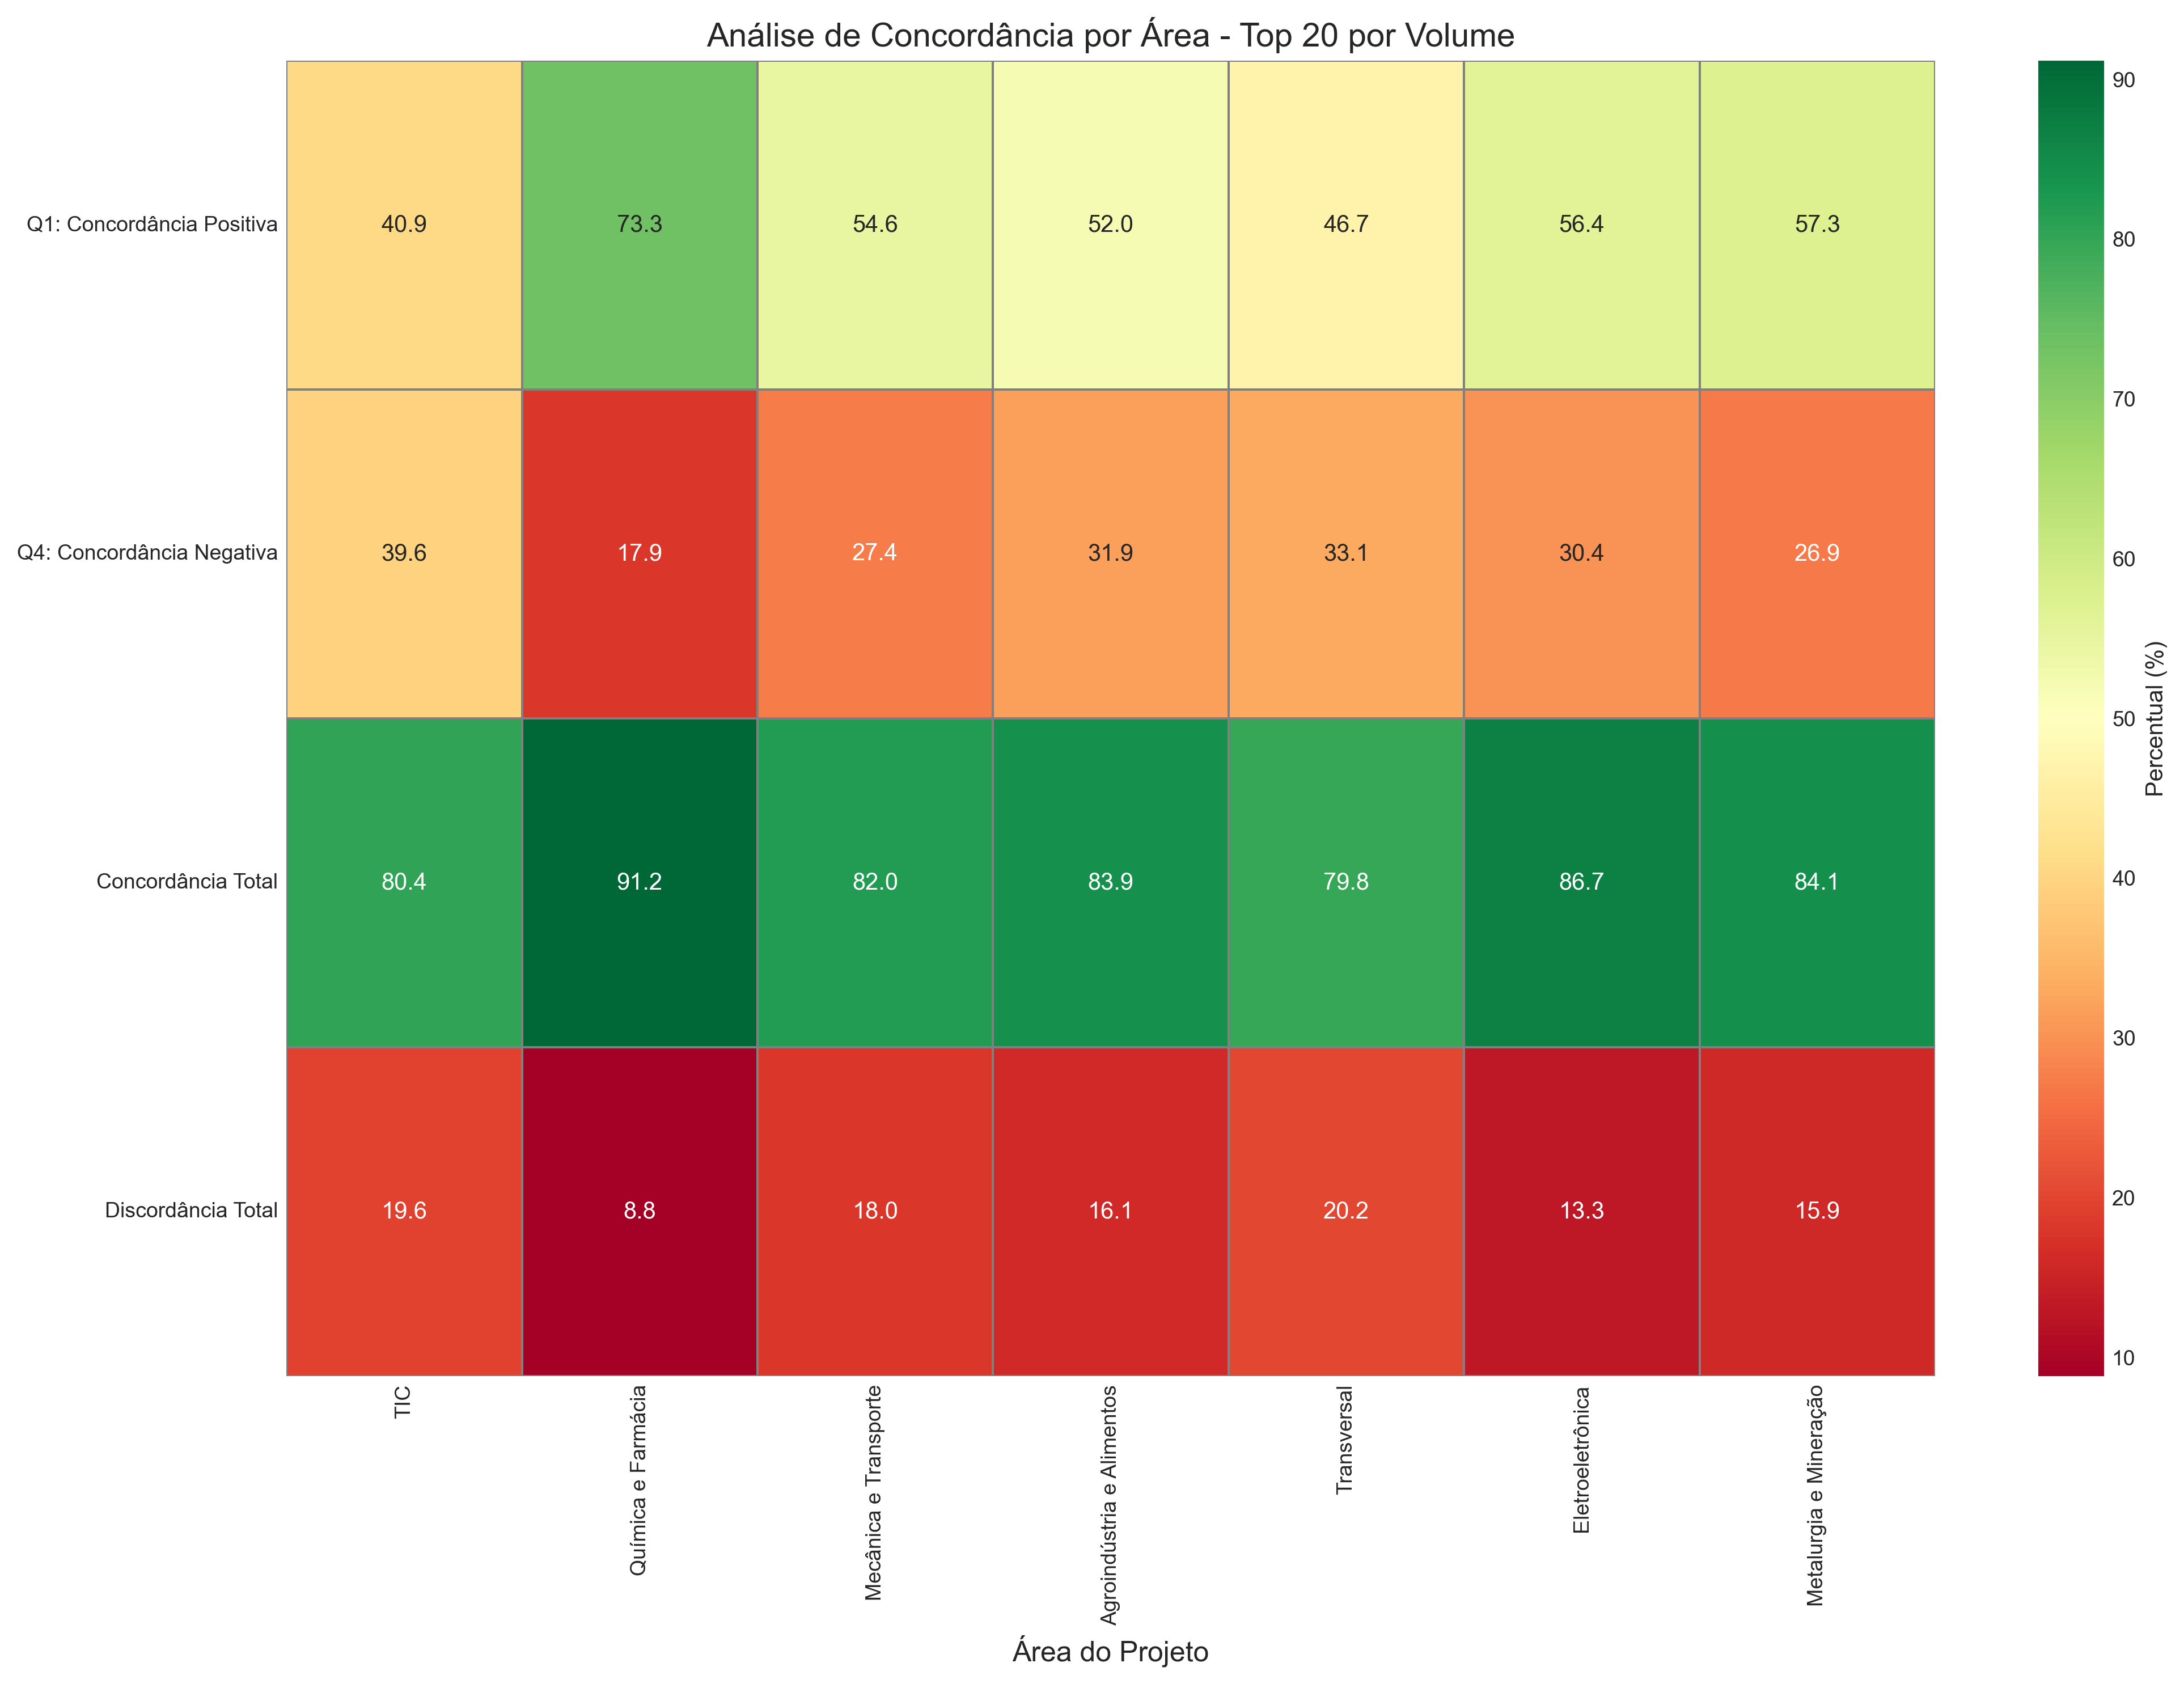


🔍 PADRÕES ESPECIAIS DE CONCORDÂNCIA:
--------------------------------------------------------------------------------

✅ Áreas com ALTA concordância positiva (Q1 > 70%):
   • Química e Farmácia: 73.3% (9415 de 12845 projetos)

⚖️ Áreas EQUILIBRADAS (diferença Q1-Q4 < 10%):
   • TIC: Q1=40.9%, Q4=39.6% (18772 projetos)

💾 Resultados exportados para 'analise_concordancia_por_area.csv'


In [31]:
if 'df_analise_quadrantes' in locals() and 'do_set_nosetor' in df_analise_quadrantes.columns:
    
    # Visualização 3: Heatmap de concordância
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Preparar dados para heatmap (top 20 áreas)
    heatmap_data = df_concordancia.head(20)[['Q1_Percent', 'Q4_Percent', 
                                             'Concordancia_Total_%', 'Discordancia_Total_%']]
    
    # Truncar nomes das áreas
    areas_truncadas = [area[:30] + '...' if len(area) > 30 else area for area in df_concordancia.head(20)['Area']]
    heatmap_data.index = areas_truncadas
    
    sns.heatmap(heatmap_data.T, annot=True, fmt='.1f', cmap='RdYlGn', center=50,
               cbar_kws={'label': 'Percentual (%)'}, linewidths=0.5, linecolor='gray')
    
    ax.set_xlabel('Área do Projeto', fontsize=12)
    ax.set_yticklabels(['Q1: Concordância Positiva', 'Q4: Concordância Negativa', 
                       'Concordância Total', 'Discordância Total'], rotation=0)
    ax.set_title('Análise de Concordância por Área - Top 20 por Volume', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Análise de padrões especiais
    print("\n🔍 PADRÕES ESPECIAIS DE CONCORDÂNCIA:")
    print("-" * 80)
    
    # Áreas com alta concordância positiva (Q1 > 70%)
    alta_concordancia_positiva = df_concordancia[df_concordancia['Q1_Percent'] > 70]
    if len(alta_concordancia_positiva) > 0:
        print(f"\n✅ Áreas com ALTA concordância positiva (Q1 > 70%):")
        for _, row in alta_concordancia_positiva.head(5).iterrows():
            print(f"   • {row['Area']}: {row['Q1_Percent']:.1f}% ({row['Q1_Ambos_Recomendam']} de {row['Total_Projetos']} projetos)")
    
    # Áreas com alta concordância negativa (Q4 > 50%)
    alta_concordancia_negativa = df_concordancia[df_concordancia['Q4_Percent'] > 50]
    if len(alta_concordancia_negativa) > 0:
        print(f"\n❌ Áreas com ALTA concordância negativa (Q4 > 50%):")
        for _, row in alta_concordancia_negativa.head(5).iterrows():
            print(f"   • {row['Area']}: {row['Q4_Percent']:.1f}% ({row['Q4_Ambos_Nao_Recomendam']} de {row['Total_Projetos']} projetos)")
    
    # Áreas equilibradas (Q1 ≈ Q4)
    df_concordancia['diferenca_q1_q4'] = abs(df_concordancia['Q1_Percent'] - df_concordancia['Q4_Percent'])
    areas_equilibradas = df_concordancia[df_concordancia['diferenca_q1_q4'] < 10]
    if len(areas_equilibradas) > 0:
        print(f"\n⚖️ Áreas EQUILIBRADAS (diferença Q1-Q4 < 10%):")
        for _, row in areas_equilibradas.head(5).iterrows():
            print(f"   • {row['Area']}: Q1={row['Q1_Percent']:.1f}%, Q4={row['Q4_Percent']:.1f}% ({row['Total_Projetos']} projetos)")
    
    # Exportar resultados
    df_concordancia.to_csv('analise_concordancia_por_area.csv', index=False, sep=';', encoding='utf-8')
    print("\n💾 Resultados exportados para 'analise_concordancia_por_area.csv'")
    
else:
    print("\n❌ Não foi possível realizar a análise por área")
    print("Verifique se os dados necessários estão disponíveis:")
    print("- df_analise_quadrantes")
    print("- coluna 'do_set_nosetor'")

### Análise por setor para Q2 e Q3

#### Tabelas 1 e 2 - Top 5 Setores Q2 e Q3
Estas duas tabelas apresentam os cinco setores com as maiores taxas percentuais de discordância em cada quadrante.
A primeira tabela, com fundo rosa, mostra os setores onde o ministério é mais rigoroso (Q2), enquanto a segunda tabela,
com fundo azul, mostra onde o pesquisador é mais rigoroso (Q3). Cada tabela contém quatro colunas: o nome do setor, a taxa
percentual do quadrante correspondente, o número absoluto de projetos naquele quadrante e o total de projetos do setor. Os
setores estão ordenados pela taxa percentual em ordem decrescente e numerados de 1 a 5.

In [32]:
# ANÁLISE APROFUNDADA DE DISCORDÂNCIA - QUADRANTES 2 E 3
# Analista Sênior MCTI - Lei do Bem

print("=" * 100)
print("ANÁLISE APROFUNDADA DAS CAUSAS DE DISCORDÂNCIA NA AVALIAÇÃO DE PROJETOS")
print("Lei do Bem - Quadrantes 2 e 3")
print("=" * 100)

# Verificar dados necessários
if 'df_analise_quadrantes' not in locals():
    print("❌ ERRO: df_analise_quadrantes não encontrado. Execute primeiro a análise de quadrantes.")
else:
    # Adicionar classificação de quadrantes se ainda não existir
    if 'quadrante' not in df_analise_quadrantes.columns:
        df_analise_quadrantes['quadrante'] = ''
        df_analise_quadrantes.loc[
            (df_analise_quadrantes['decisao_pesquisador'] == 'Recomendado') & 
            (df_analise_quadrantes['decisao_ministerio'] == 'Recomendado'), 'quadrante'] = 'Q1'
        df_analise_quadrantes.loc[
            (df_analise_quadrantes['decisao_pesquisador'] == 'Recomendado') & 
            (df_analise_quadrantes['decisao_ministerio'] == 'Não Recomendado'), 'quadrante'] = 'Q2'
        df_analise_quadrantes.loc[
            (df_analise_quadrantes['decisao_pesquisador'] == 'Não Recomendado') & 
            (df_analise_quadrantes['decisao_ministerio'] == 'Recomendado'), 'quadrante'] = 'Q3'
        df_analise_quadrantes.loc[
            (df_analise_quadrantes['decisao_pesquisador'] == 'Não Recomendado') & 
            (df_analise_quadrantes['decisao_ministerio'] == 'Não Recomendado'), 'quadrante'] = 'Q4'
    
    # ========================================================================
    # PARTE 1: ANÁLISE SETORIAL DA DISCORDÂNCIA
    # ========================================================================
    
    print("\n📊 1. ANÁLISE SETORIAL DA DISCORDÂNCIA")
    print("-" * 80)
    
    if 'do_set_nosetor' in df_analise_quadrantes.columns:
        # Filtrar apenas registros com área definida
        df_com_area = df_analise_quadrantes[df_analise_quadrantes['do_set_nosetor'].notna()].copy()
        
        # Análise por setor
        analise_setorial = []
        
        for setor in df_com_area['do_set_nosetor'].unique():
            if pd.notna(setor):
                projetos_setor = df_com_area[df_com_area['do_set_nosetor'] == setor]
                total_setor = len(projetos_setor)
                
                if total_setor >= 10:  # Apenas setores com volume mínimo
                    q2_count = len(projetos_setor[projetos_setor['quadrante'] == 'Q2'])
                    q3_count = len(projetos_setor[projetos_setor['quadrante'] == 'Q3'])
                    
                    analise_setorial.append({
                        'Setor': setor,
                        'Total_Projetos': total_setor,
                        'Q2_Count': q2_count,
                        'Q2_Percent': (q2_count / total_setor * 100),
                        'Q3_Count': q3_count,
                        'Q3_Percent': (q3_count / total_setor * 100),
                        'Discordancia_Total_%': ((q2_count + q3_count) / total_setor * 100)
                    })
        
        df_setorial = pd.DataFrame(analise_setorial)
        
        # Top 5 setores com maior taxa de Q2
        print("\n🔴 TOP 5 SETORES - MAIOR TAXA Q2 (Pesquisador SIM → Ministério NÃO):")
        top_q2 = df_setorial.nlargest(5, 'Q2_Percent').copy()
        top_q2.reset_index(drop=True, inplace=True)
        top_q2.index = top_q2.index + 1  # Começar índice em 1
        
        # Formatar para exibição
        top_q2_display = top_q2[['Setor', 'Q2_Percent', 'Q2_Count', 'Total_Projetos']].copy()
        top_q2_display['Setor'] = top_q2_display['Setor'].str[:50]  # Truncar setores longos
        top_q2_display['Q2_Percent'] = top_q2_display['Q2_Percent'].round(1).astype(str) + '%'
        top_q2_display.columns = ['Setor', 'Taxa Q2 (%)', 'Projetos Q2', 'Total Projetos']
        
        # Aplicar estilo com pandas
        styled_q2 = top_q2_display.style\
            .set_caption("Top 5 Setores - Maior Taxa Q2 (Pesquisador SIM → Ministério NÃO)")\
            .set_properties(**{'background-color': '#ffe6e6', 'border': '1px solid #ddd'})\
            .set_table_styles([
                {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('margin-bottom', '10px')]},
                {'selector': 'th', 'props': [('background-color', '#ffcccc'), ('font-weight', 'bold')]}
            ])
        
        # Exibir tabela
        display(styled_q2)
        
        # Exportar para CSV
        top_q2.to_csv('top5_setores_q2.csv', index=True, sep=';', encoding='utf-8')
        
        # Top 5 setores com maior taxa de Q3
        print("\n🔵 TOP 5 SETORES - MAIOR TAXA Q3 (Pesquisador NÃO → Ministério SIM):")
        top_q3 = df_setorial.nlargest(5, 'Q3_Percent').copy()
        top_q3.reset_index(drop=True, inplace=True)
        top_q3.index = top_q3.index + 1
        
        # Formatar para exibição
        top_q3_display = top_q3[['Setor', 'Q3_Percent', 'Q3_Count', 'Total_Projetos']].copy()
        top_q3_display['Setor'] = top_q3_display['Setor'].str[:50]
        top_q3_display['Q3_Percent'] = top_q3_display['Q3_Percent'].round(1).astype(str) + '%'
        top_q3_display.columns = ['Setor', 'Taxa Q3 (%)', 'Projetos Q3', 'Total Projetos']
        
        # Aplicar estilo com pandas
        styled_q3 = top_q3_display.style\
            .set_caption("Top 5 Setores - Maior Taxa Q3 (Pesquisador NÃO → Ministério SIM)")\
            .set_properties(**{'background-color': '#e6f3ff', 'border': '1px solid #ddd'})\
            .set_table_styles([
                {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('margin-bottom', '10px')]},
                {'selector': 'th', 'props': [('background-color', '#cce6ff'), ('font-weight', 'bold')]}
            ])
        
        display(styled_q3)
        
        # Exportar para CSV
        top_q3.to_csv('top5_setores_q3.csv', index=True, sep=';', encoding='utf-8')
        

ANÁLISE APROFUNDADA DAS CAUSAS DE DISCORDÂNCIA NA AVALIAÇÃO DE PROJETOS
Lei do Bem - Quadrantes 2 e 3

📊 1. ANÁLISE SETORIAL DA DISCORDÂNCIA
--------------------------------------------------------------------------------

🔴 TOP 5 SETORES - MAIOR TAXA Q2 (Pesquisador SIM → Ministério NÃO):


,Setor,Taxa Q2 (%),Projetos Q2,Total Projetos
1,TIC,12.1%,2268,18772
2,Transversal,11.8%,879,7467
3,Agroindústria e Alimentos,8.5%,694,8144
4,Metalurgia e Mineração,5.6%,277,4989
5,Mecânica e Transporte,4.5%,404,9068



🔵 TOP 5 SETORES - MAIOR TAXA Q3 (Pesquisador NÃO → Ministério SIM):


,Setor,Taxa Q3 (%),Projetos Q3,Total Projetos
1,Mecânica e Transporte,13.6%,1230,9068
2,Eletroeletrônica,11.1%,792,7158
3,Metalurgia e Mineração,10.3%,514,4989
4,Transversal,8.4%,630,7467
5,Agroindústria e Alimentos,7.5%,614,8144


#### Gráfico 10 - Análise Setorial de Discordância: Q2 vs Q3

Este gráfico de barras agrupadas compara as taxas de discordância entre os Quadrantes 2 e 3 para os 15 setores com maior volume de projetos. As barras vermelhas representam o Q2 (projetos recomendados pelo pesquisador mas não recomendados pelo ministério) e as barras azuis representam o Q3 (projetos não recomendados pelo pesquisador mas recomendados pelo ministério).

Cada par de barras corresponde a um setor específico, com os valores percentuais exibidos acima de cada barra. As linhas horizontais tracejadas indicam as médias gerais de Q2 (8,8%) e Q3 (4,3%) em todos os setores. O gráfico permite visualizar quais setores apresentam maior discordância e em qual direção essa discordância ocorre predominantemente.

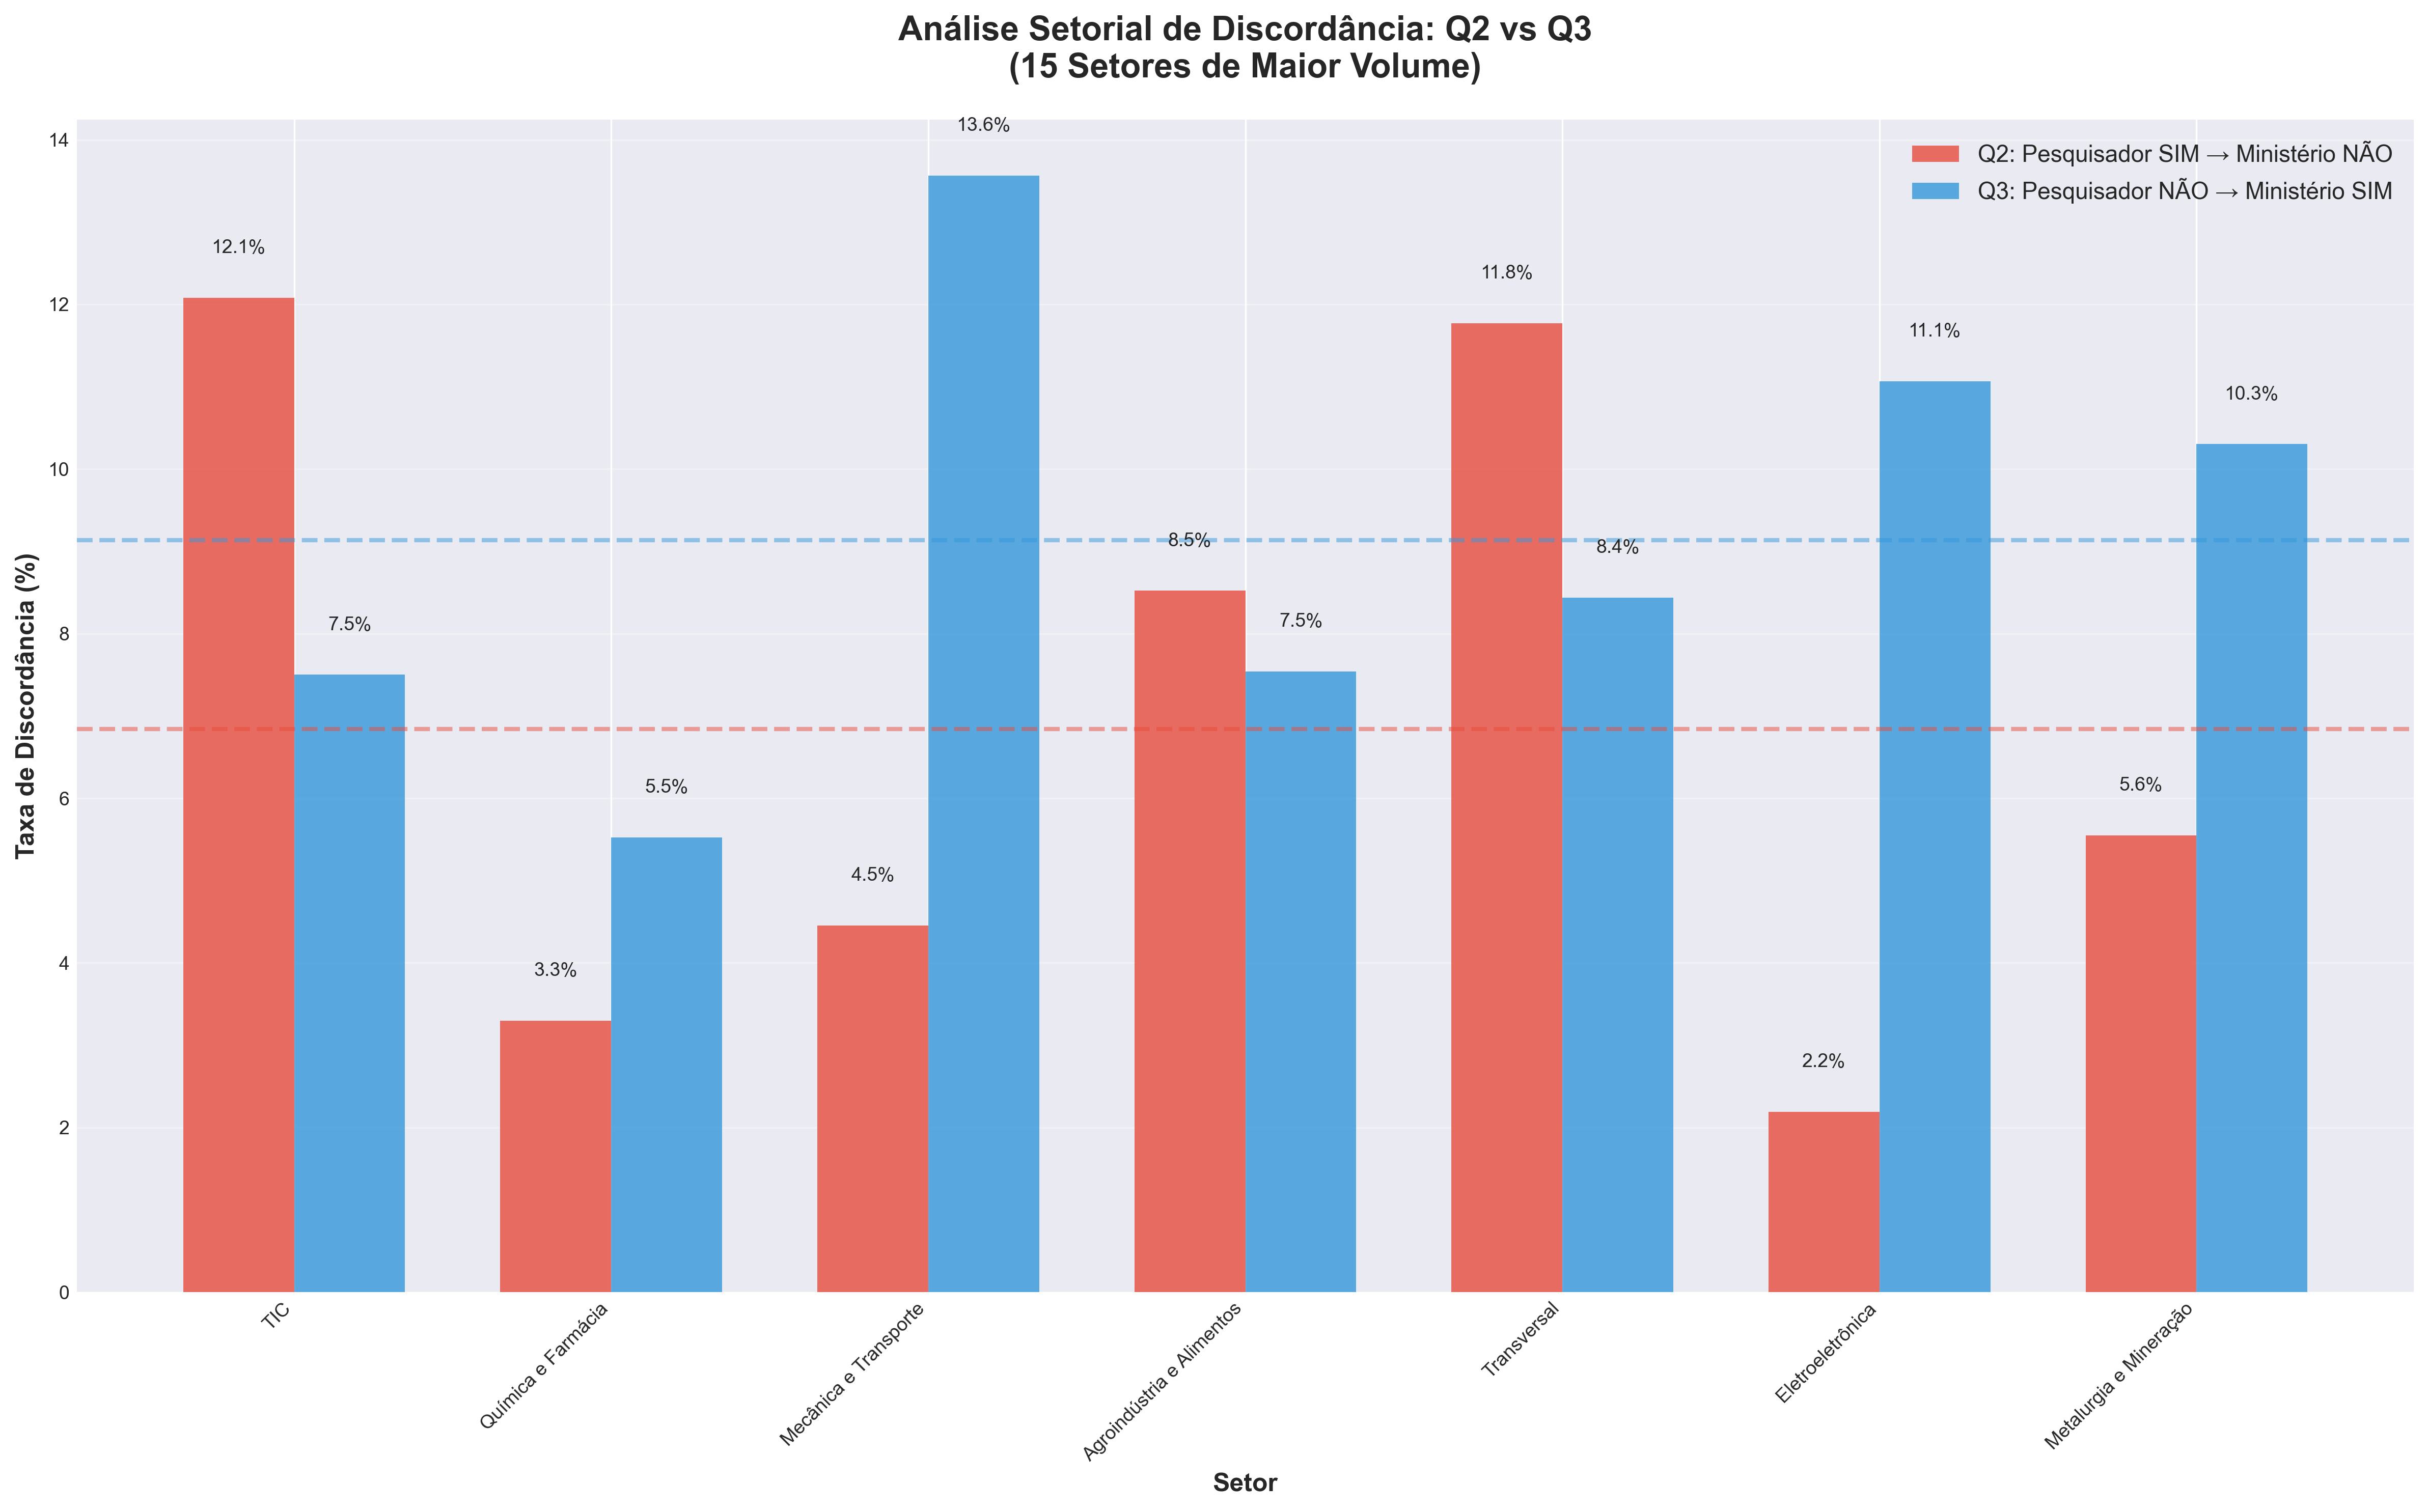


📈 ANÁLISE DE PADRÕES SETORIAIS:
--------------------------------------------------------------------------------


In [33]:
if 'df_analise_quadrantes' not in locals():
    print("❌ ERRO: df_analise_quadrantes não encontrado. Execute primeiro a análise de quadrantes.")
else:
    if 'do_set_nosetor' in df_analise_quadrantes.columns:
        # Visualização: Comparação Q2 vs Q3 nos 15 maiores setores
        fig, ax = plt.subplots(figsize=(16, 10))
        
        # Top 15 setores por volume
        top_setores = df_setorial.nlargest(15, 'Total_Projetos')
        
        x = np.arange(len(top_setores))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, top_setores['Q2_Percent'], width, 
                       label='Q2: Pesquisador SIM → Ministério NÃO', 
                       color='#e74c3c', alpha=0.8)
        bars2 = ax.bar(x + width/2, top_setores['Q3_Percent'], width,
                       label='Q3: Pesquisador NÃO → Ministério SIM', 
                       color='#3498db', alpha=0.8)
        
        # Adicionar valores nas barras
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                           f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Configurar gráfico
        ax.set_xlabel('Setor', fontsize=12, fontweight='bold')
        ax.set_ylabel('Taxa de Discordância (%)', fontsize=12, fontweight='bold')
        ax.set_title('Análise Setorial de Discordância: Q2 vs Q3\n(15 Setores de Maior Volume)', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xticks(x)
        labels_setores = [setor[:25] + '...' if len(setor) > 25 else setor for setor in top_setores['Setor']]
        ax.set_xticklabels(labels_setores, rotation=45, ha='right')
        ax.legend(loc='upper right', fontsize=11)
        ax.grid(axis='y', alpha=0.3)
        
        # Adicionar linha média
        media_q2 = df_setorial['Q2_Percent'].mean()
        media_q3 = df_setorial['Q3_Percent'].mean()
        ax.axhline(y=media_q2, color='#e74c3c', linestyle='--', alpha=0.5, linewidth=2)
        ax.axhline(y=media_q3, color='#3498db', linestyle='--', alpha=0.5, linewidth=2)
        
        plt.tight_layout()
        plt.show()
        
        # Análise de padrões setoriais
        print("\n📈 ANÁLISE DE PADRÕES SETORIAIS:")
        print("-" * 80)

#### Tabelas 3 e 4 - Viés do Ministério e do Pesquisador
Estas tabelas identificam setores onde há um viés significativo (diferença maior que 5%) entre Q2 e Q3. A tabela de viés do ministério mostra setores onde Q2 > Q3 + 5%, indicando que o ministério tende a ser mais rigoroso nesses setores. A tabela de viés do pesquisador mostra o oposto (Q3 > Q2 + 5%). Cada tabela apresenta as taxas de Q2 e Q3, a diferença entre elas (Δ) e o total de projetos. A coluna de diferença é destacada com cor de fundo correspondente ao tipo de viés (rosa para ministério, azul para pesquisador).

In [34]:
if 'df_analise_quadrantes' not in locals():
    print("❌ ERRO: df_analise_quadrantes não encontrado. Execute primeiro a análise de quadrantes.")
else:
    if 'do_set_nosetor' in df_analise_quadrantes.columns:
        # Setores com viés Q2 (Ministério mais rigoroso)
        setores_vies_q2 = df_setorial[df_setorial['Q2_Percent'] > df_setorial['Q3_Percent'] + 5].copy()
        if len(setores_vies_q2) > 0:
            print(f"\n🔴 Setores onde o MINISTÉRIO é mais RIGOROSO (Q2 > Q3 + 5%):")
            
            # Preparar dados para tabela
            vies_q2_display = setores_vies_q2.nlargest(5, 'Total_Projetos').copy()
            vies_q2_display['Diferenca'] = vies_q2_display['Q2_Percent'] - vies_q2_display['Q3_Percent']
            vies_q2_display.reset_index(drop=True, inplace=True)
            vies_q2_display.index = vies_q2_display.index + 1
            
            # Formatar para exibição
            vies_q2_show = vies_q2_display[['Setor', 'Q2_Percent', 'Q3_Percent', 'Diferenca', 'Total_Projetos']].copy()
            vies_q2_show['Setor'] = vies_q2_show['Setor'].str[:40]
            vies_q2_show['Q2_Percent'] = vies_q2_show['Q2_Percent'].round(1).astype(str) + '%'
            vies_q2_show['Q3_Percent'] = vies_q2_show['Q3_Percent'].round(1).astype(str) + '%'
            vies_q2_show['Diferenca'] = '+' + vies_q2_show['Diferenca'].round(1).astype(str) + '%'
            vies_q2_show.columns = ['Setor', 'Q2 (%)', 'Q3 (%)', 'Δ (Q2-Q3)', 'Total']
            
            # Aplicar estilo
            styled_vies_q2 = vies_q2_show.style\
                .set_caption("Viés do Ministério - Setores onde Q2 > Q3 + 5%")\
                .set_properties(**{'border': '1px solid #ddd'})\
                .apply(lambda x: ['background-color: #ffcccc' if x.name == 'Δ (Q2-Q3)' else 'background-color: #fff' for i in x], axis=0)\
                .set_table_styles([
                    {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold'), ('margin-bottom', '10px')]},
                    {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]}
                ])
            
            display(styled_vies_q2)
            
            # Exportar para CSV
            vies_q2_display.to_csv('setores_vies_ministerio_q2.csv', index=True, sep=';', encoding='utf-8')
        
        # Setores com viés Q3 (Pesquisador mais rigoroso)
        setores_vies_q3 = df_setorial[df_setorial['Q3_Percent'] > df_setorial['Q2_Percent'] + 5].copy()
        if len(setores_vies_q3) > 0:
            print(f"\n🔵 Setores onde o PESQUISADOR é mais RIGOROSO (Q3 > Q2 + 5%):")
            
            # Preparar dados para tabela
            vies_q3_display = setores_vies_q3.nlargest(5, 'Total_Projetos').copy()
            vies_q3_display['Diferenca'] = vies_q3_display['Q3_Percent'] - vies_q3_display['Q2_Percent']
            vies_q3_display.reset_index(drop=True, inplace=True)
            vies_q3_display.index = vies_q3_display.index + 1
            
            # Formatar para exibição
            vies_q3_show = vies_q3_display[['Setor', 'Q3_Percent', 'Q2_Percent', 'Diferenca', 'Total_Projetos']].copy()
            vies_q3_show['Setor'] = vies_q3_show['Setor'].str[:40]
            vies_q3_show['Q3_Percent'] = vies_q3_show['Q3_Percent'].round(1).astype(str) + '%'
            vies_q3_show['Q2_Percent'] = vies_q3_show['Q2_Percent'].round(1).astype(str) + '%'
            vies_q3_show['Diferenca'] = '+' + vies_q3_show['Diferenca'].round(1).astype(str) + '%'
            vies_q3_show.columns = ['Setor', 'Q3 (%)', 'Q2 (%)', 'Δ (Q3-Q2)', 'Total']
            
            # Aplicar estilo
            styled_vies_q3 = vies_q3_show.style\
                .set_caption("Viés do Pesquisador - Setores onde Q3 > Q2 + 5%")\
                .set_properties(**{'border': '1px solid #ddd'})\
                .apply(lambda x: ['background-color: #cce6ff' if x.name == 'Δ (Q3-Q2)' else 'background-color: #fff' for i in x], axis=0)\
                .set_table_styles([
                    {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold'), ('margin-bottom', '10px')]},
                    {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]}
                ])
            
            display(styled_vies_q3)
            
            # Exportar para CSV
            vies_q3_display.to_csv('setores_vies_pesquisador_q3.csv', index=True, sep=';', encoding='utf-8')
        
        # Tabela resumo geral de discordância setorial
        print("\n📊 RESUMO GERAL DE DISCORDÂNCIA POR SETOR:")
        
        print("""
              
              """)


🔵 Setores onde o PESQUISADOR é mais RIGOROSO (Q3 > Q2 + 5%):


,Setor,Q3 (%),Q2 (%),Δ (Q3-Q2),Total
1,Mecânica e Transporte,13.6%,4.5%,+9.1%,9068
2,Eletroeletrônica,11.1%,2.2%,+8.9%,7158



📊 RESUMO GERAL DE DISCORDÂNCIA POR SETOR:

              
              


#### Tabela 5 - Resumo Geral de Discordância por Setor
Esta tabela apresenta os 10 setores com maior taxa de discordância total (Q2 + Q3). As colunas mostram o nome do setor, a taxa de discordância total, as taxas individuais de Q2 e Q3, qual avaliador é mais rigoroso naquele setor (colorido em rosa se for o ministério ou azul se for o pesquisador), e o total de projetos. O setor TIC - Software lidera com 34,8% de discordância total. A coloração na coluna "Mais Rigoroso" facilita a identificação visual de padrões de rigor por setor, mostrando se há tendências sistemáticas em determinadas áreas.

In [ ]:
if 'df_analise_quadrantes' not in locals():
    print("❌ ERRO: df_analise_quadrantes não encontrado. Execute primeiro a análise de quadrantes.")
else:
    if 'do_set_nosetor' in df_analise_quadrantes.columns:
        # Top 10 setores com maior discordância total
        top_discordancia = df_setorial.nlargest(10, 'Discordancia_Total_%').copy()
        top_discordancia['Dominancia'] = top_discordancia.apply(
            lambda row: 'Ministério' if row['Q2_Percent'] > row['Q3_Percent'] else 'Pesquisador', axis=1
        )
        top_discordancia.reset_index(drop=True, inplace=True)
        top_discordancia.index = top_discordancia.index + 1
        
        # Formatar para exibição
        disc_show = top_discordancia[['Setor', 'Discordancia_Total_%', 'Q2_Percent', 'Q3_Percent', 'Dominancia', 'Total_Projetos']].copy()
        disc_show['Setor'] = disc_show['Setor'].str[:35]
        disc_show['Discordancia_Total_%'] = disc_show['Discordancia_Total_%'].round(1).astype(str) + '%'
        disc_show['Q2_Percent'] = disc_show['Q2_Percent'].round(1).astype(str) + '%'
        disc_show['Q3_Percent'] = disc_show['Q3_Percent'].round(1).astype(str) + '%'
        disc_show.columns = ['Setor', 'Discord. Total', 'Q2 (%)', 'Q3 (%)', 'Mais Rigoroso', 'Total']
        
        # Função para aplicar cores baseadas na dominância
        def highlight_dominance(s):
            colors = []
            for val in s:
                if val == 'Ministério':
                    colors.append('background-color: #ffe6e6')
                elif val == 'Pesquisador':
                    colors.append('background-color: #e6f3ff')
                else:
                    colors.append('background-color: white')
            return colors
        
        # Aplicar estilo
        styled_disc = disc_show.style\
            .set_caption("Top 10 Setores - Maior Discordância Total")\
            .set_properties(**{'border': '1px solid #ddd'})\
            .apply(highlight_dominance, subset=['Mais Rigoroso'])\
            .apply(lambda x: ['background-color: #f0f0f0' if x.name == 'Discord. Total' else '' for i in x], axis=0)\
            .set_table_styles([
                {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('margin-bottom', '10px')]},
                {'selector': 'th', 'props': [('background-color', '#d0d0d0'), ('font-weight', 'bold')]}
            ])
        
        display(styled_disc)
        
        # Exportar para CSV
        top_discordancia.to_csv('resumo_discordancia_setorial.csv', index=True, sep=';', encoding='utf-8')
    
    # ========================================================================
    # PARTE 2: ANÁLISE DE FREQUÊNCIA DAS JUSTIFICATIVAS
    # ========================================================================
        
    # Análise Q2: Justificativas do MINISTÉRIO para não recomendar
    df_q2 = df_analise_quadrantes[df_analise_quadrantes['quadrante'] == 'Q2'].copy()
    
    # Verificar campos de justificativa do Ministério
    if 'p_japroj_nojustificativaanalise' in df_q2.columns and 'p_japroj_nocorpojustificativaanalise' in df_q2.columns:
        # Concatenar título e corpo da justificativa
        df_q2['justificativa_ministerio'] = (
            df_q2['p_japroj_nojustificativaanalise'].fillna('') + ' - ' + 
            df_q2['p_japroj_nocorpojustificativaanalise'].fillna('')
        )
        
        # Remover vazios
        df_q2_just = df_q2[df_q2['justificativa_ministerio'].str.strip() != ' - ']
        
        if len(df_q2_just) > 0:
            # Análise de frequência
            freq_just_ministerio = df_q2_just['justificativa_ministerio'].value_counts()
            
            print(f"\n📊 TOP 10 JUSTIFICATIVAS DO MINISTÉRIO (Q2):")
            print("-" * 80)
            for i, (just, count) in enumerate(freq_just_ministerio.head(10).items(), 1):
                percent = count / len(df_q2_just) * 100
                print(f"{i:2d}. [{count:4d} | {percent:5.1f}%] {just[:100]}{'...' if len(just) > 100 else ''}")
            
            # Visualização das justificativas Q2
            fig, ax = plt.subplots(figsize=(12, 8))
            
            top_just = freq_just_ministerio.head(10)
            y_pos = np.arange(len(top_just))
            
            bars = ax.barh(y_pos, top_just.values, color='#e74c3c', alpha=0.8)
            
            # Truncar labels longas
            labels = [just[:60] + '...' if len(just) > 60 else just for just in top_just.index]
            ax.set_yticks(y_pos)
            ax.set_yticklabels(labels, fontsize=10)
            ax.invert_yaxis()
            ax.set_xlabel('Frequência', fontsize=12)
            ax.set_title('Q2: Top 10 Justificativas do Ministério para NÃO Recomendar\n(Projetos recomendados pelo Pesquisador)', 
                        fontsize=14, fontweight='bold', pad=20)
            ax.grid(axis='x', alpha=0.3)
            
            # Adicionar valores nas barras
            for i, (bar, valor) in enumerate(zip(bars, top_just.values)):
                percent = valor / len(df_q2_just) * 100
                ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, 
                       f'{valor} ({percent:.1f}%)', va='center', fontsize=9)
            
            plt.tight_layout()
            plt.show()
    
    # Análise Q3: Justificativas do PESQUISADOR para não recomendar
    df_q3 = df_analise_quadrantes[df_analise_quadrantes['quadrante'] == 'Q3'].copy()
    
    # Verificar campos de justificativa do Pesquisador
    if 'do_japroj_nojustificativaanalise' in df_q3.columns and 'do_japroj_nocorpojustificativaanalise' in df_q3.columns:
        # Concatenar título e corpo da justificativa
        df_q3['justificativa_pesquisador'] = (
            df_q3['do_japroj_nojustificativaanalise'].fillna('') + ' - ' + 
            df_q3['do_japroj_nocorpojustificativaanalise'].fillna('')
        )
        
        # Remover vazios
        df_q3_just = df_q3[df_q3['justificativa_pesquisador'].str.strip() != ' - ']
        
        if len(df_q3_just) > 0:
            # Análise de frequência
            freq_just_pesquisador = df_q3_just['justificativa_pesquisador'].value_counts()
            
            print(f"\n📊 TOP 10 JUSTIFICATIVAS DO PESQUISADOR (Q3):")
            print("-" * 80)
            for i, (just, count) in enumerate(freq_just_pesquisador.head(10).items(), 1):
                percent = count / len(df_q3_just) * 100
                print(f"{i:2d}. [{count:4d} | {percent:5.1f}%] {just[:100]}{'...' if len(just) > 100 else ''}")
            
            # Visualização das justificativas Q3
            fig, ax = plt.subplots(figsize=(12, 8))
            
            top_just = freq_just_pesquisador.head(10)
            y_pos = np.arange(len(top_just))
            
            bars = ax.barh(y_pos, top_just.values, color='#3498db', alpha=0.8)
            
            # Truncar labels longas
            labels = [just[:60] + '...' if len(just) > 60 else just for just in top_just.index]
            ax.set_yticks(y_pos)
            ax.set_yticklabels(labels, fontsize=10)
            ax.invert_yaxis()
            ax.set_xlabel('Frequência', fontsize=12)
            ax.set_title('Q3: Top 10 Justificativas do Pesquisador para NÃO Recomendar\n(Projetos recomendados pelo Ministério)', 
                        fontsize=14, fontweight='bold', pad=20)
            ax.grid(axis='x', alpha=0.3)
            
            # Adicionar valores nas barras
            for i, (bar, valor) in enumerate(zip(bars, top_just.values)):
                percent = valor / len(df_q3_just) * 100
                ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, 
                       f'{valor} ({percent:.1f}%)', va='center', fontsize=9)
            
            plt.tight_layout()
            plt.show()
    
    # ========================================================================
    # PARTE 3: ANÁLISE COMPARATIVA E INSIGHTS
    # ========================================================================
    
    print("\n\n🔍 2. ANÁLISE COMPARATIVA E INSIGHTS")
    print("-" * 80)
    
    # Categorizar as justificativas por tipo
    if 'freq_just_ministerio' in locals() and 'freq_just_pesquisador' in locals():
        print("\n📊 CATEGORIZAÇÃO DAS JUSTIFICATIVAS:")
        
        # Palavras-chave para categorização
        categorias = {
            'Aspectos Formais/Documentais': ['clareza', 'documentação', 'metodologia', 'descrição', 'detalhamento'],
            'Mérito da Inovação': ['inovação', 'tecnológico', 'originalidade', 'estado da arte', 'avanço'],
            'Enquadramento': ['enquadramento', 'requisitos', 'critérios', 'elegibilidade'],
            'Aspectos Técnicos': ['técnico', 'viabilidade', 'complexidade', 'desafio']
        }
        
        # Análise de categorias para Q2 (Ministério)
        print("\n🔴 FOCO DO MINISTÉRIO (Q2):")
        categorias_ministerio = {cat: 0 for cat in categorias}
        
        for just, count in freq_just_ministerio.head(10).items():
            just_lower = just.lower()
            for categoria, palavras in categorias.items():
                if any(palavra in just_lower for palavra in palavras):
                    categorias_ministerio[categoria] += count
        
        total_cat_min = sum(categorias_ministerio.values())
        for cat, count in sorted(categorias_ministerio.items(), key=lambda x: x[1], reverse=True):
            if count > 0:
                print(f"   • {cat}: {count} ocorrências ({count/total_cat_min*100:.1f}%)")
        
        # Análise de categorias para Q3 (Pesquisador)
        print("\n🔵 FOCO DO PESQUISADOR (Q3):")
        categorias_pesquisador = {cat: 0 for cat in categorias}
        
        for just, count in freq_just_pesquisador.head(10).items():
            just_lower = just.lower()
            for categoria, palavras in categorias.items():
                if any(palavra in just_lower for palavra in palavras):
                    categorias_pesquisador[categoria] += count
        
        total_cat_pesq = sum(categorias_pesquisador.values())
        for cat, count in sorted(categorias_pesquisador.items(), key=lambda x: x[1], reverse=True):
            if count > 0:
                print(f"   • {cat}: {count} ocorrências ({count/total_cat_pesq*100:.1f}%)")
    
    # ========================================================================
    # RECOMENDAÇÕES FINAIS
    # ========================================================================
    
    print("\n\n💡 RECOMENDAÇÕES PARA REDUÇÃO DA SUBJETIVIDADE")
    print("=" * 80)
    
    print("""
1. **HARMONIZAÇÃO DE CRITÉRIOS POR SETOR:**
   - Desenvolver guias específicos para setores com alta discordância
   - Realizar workshops de alinhamento entre avaliadores por área temática

2. **PADRONIZAÇÃO DE INTERPRETAÇÕES:**
   - Criar exemplos concretos do que constitui "inovação suficiente" por setor
   - Estabelecer métricas objetivas para avaliar "clareza metodológica"

3. **SISTEMA DE DUPLA CHECAGEM:**
   - Implementar revisão obrigatória para projetos em setores de alta discordância
   - Criar comitês mistos (pesquisador + analista) para casos limítrofes

4. **CAPACITAÇÃO CONTINUADA:**
   - Treinar analistas do Ministério em aspectos técnicos específicos
   - Sensibilizar pesquisadores sobre requisitos formais e de enquadramento

5. **FEEDBACK ESTRUTURADO:**
   - Implementar sistema de justificativas estruturadas com campos obrigatórios
   - Criar base de conhecimento com decisões anteriores como referência
    """)
    
    # Exportar resultados
    if 'df_setorial' in locals():
        df_setorial.to_csv('analise_discordancia_setorial_q2_q3.csv', index=False, sep=';', encoding='utf-8')
        print("\n💾 Análise setorial exportada para 'analise_discordancia_setorial_q2_q3.csv'")

,Setor,Discord. Total,Q2 (%),Q3 (%),Mais Rigoroso,Total
1,Transversal,20.2%,11.8%,8.4%,Ministério,7467
2,TIC,19.6%,12.1%,7.5%,Ministério,18772
3,Mecânica e Transporte,18.0%,4.5%,13.6%,Pesquisador,9068
4,Agroindústria e Alimentos,16.1%,8.5%,7.5%,Ministério,8144
5,Metalurgia e Mineração,15.9%,5.6%,10.3%,Pesquisador,4989
6,Eletroeletrônica,13.3%,2.2%,11.1%,Pesquisador,7158
7,Química e Farmácia,8.8%,3.3%,5.5%,Pesquisador,12845




🔍 3. ANÁLISE COMPARATIVA E INSIGHTS
--------------------------------------------------------------------------------


💡 RECOMENDAÇÕES PARA REDUÇÃO DA SUBJETIVIDADE

1. **HARMONIZAÇÃO DE CRITÉRIOS POR SETOR:**
   - Desenvolver guias específicos para setores com alta discordância
   - Realizar workshops de alinhamento entre avaliadores por área temática

2. **PADRONIZAÇÃO DE INTERPRETAÇÕES:**
   - Criar exemplos concretos do que constitui "inovação suficiente" por setor
   - Estabelecer métricas objetivas para avaliar "clareza metodológica"

3. **SISTEMA DE DUPLA CHECAGEM:**
   - Implementar revisão obrigatória para projetos em setores de alta discordância
   - Criar comitês mistos (pesquisador + analista) para casos limítrofes

4. **CAPACITAÇÃO CONTINUADA:**
   - Treinar analistas do Ministério em aspectos técnicos específicos
   - Sensibilizar pesquisadores sobre requisitos formais e de enquadramento

5. **FEEDBACK ESTRUTURADO:**
   - Implementar sistema de justificativas estruturad